# Used Car Listing Price Range Prediction

---

<center><img src="https://raw.githubusercontent.com/anthonynamnam/anthonynamnam/main/icons/image/car-banner.png" alt="memes" width="600" /></center>

---

## Project Overview <a class="anchor" id="overview"></a>

Please kindly refer to the github repo of this project: [Link](https://github.com/anthonynamnam/brainstation_capstone#project-overview)


---

## Notebook Overview <a class="anchor" id="overview"></a>

In this notebook, we will go through part of our project, which is the sprint 1 of our project.

Sprint 1 Content:
- Understand Data 
- Data Assessment
- Data Cleaning
- Data Preprocessing
- Exploratory Data Analysis

Next Sprint:
- Hypothese Testing
- Feature Engineering
- Feature Selection
- Baseline Modelling
- Model Development


---

## Table of Contents <a class="anchor" id="toc"></a>

- [Dataset](#data)
- [Notebook Set Up](#setup)
- [Functions](#func)
- [Data Loading](#load)
- [Data Assessment](#assess)
- [Data Cleaning](#clean)
- [Data Preprocessing](#preprocess)
- [Exploratory Data Analysis](#eda)

---

## Dataset<a class="anchor" id="data"></a>

Table of Contents for this part: 
- [Data Description](#data-desc)
- [Data Dictionary](#data-dict)
- [Data Source Link](#data-link)
- [Data Coverage](#data-coverage)

### Dataset Description <a class="anchor" id="data-desc"></a>

- There are two separate datasets for Canada data (CA) and United States data (US). However, some data are wrong located. For example, there are records with `city` of `Burnaby` and `state` of `BC` in the US dataset.
- We will concatenate both datasets together and generate a column `country` during feature engineering stage.
- Both dataset have the same set of columns.
- Dimension of the Datasets:
    |Filename|Country|#. of Rows|#. of Columns|
    |---|---|---|---|
    |`data/ca-dealers-used.csv`|`CA`|393603|21|
    |`data/us-dealers-used.csv`|`US`|7104304|21|
    ||**TOTAL**|7,497,907|21|

### Data Dictionary <a class="anchor" id="data-dict"></a>

|Column|Data Type|Description|Remarks/Examples|
|:---|:---|:---|:---|
|`id`|`str`|Unique ID for each listing on different platforms.||
|`vin`|`str`|`V`ehicle `I`dentifier `N`umber: A 17-char long unique string assigned to the vehicle.||
|`price`|`float`|The listing price of the vehicle on the website.||
|`miles`|`float`|The miles travelled / odometer value listed on the website.||
|`stock_no`|`str`|Stock number of the car listed on the website.||
|`year`|`int`|Model Year of the vehicle.||
|`make`|`str`|Manufacturer of the vehicle.||
|`model`|`str`|Model of the vehicle.||
|`trim`|`str`|Trim Year of the vehicle.||
|`body_type`|`str`|Body type of the vehicle.||
|`vehicle_type`|`str`|Vehicle type of the vehicle.||
|`drivetrain`|`str`|Drivetrain type of the vehicle.||
|`transmission`|`str`|Transmission type of the vehicle.||
|`fuel_type`|`str`|Supported fuel type of the vehicle.|Multiple fuel types in one cell|
|`engine_size`|`float`|Size of the vehicle engine||
|`engine_block`|`str`|Type of the vehicle engine||
|`seller_name`|`str`|Name of the Dealer||
|`street`|`str`|Dealer Location (Street)||
|`city`|`str`|Dealer Location (City)||
|`state`|`str`|Dealer Location (State)||
|`zip`|`str`|Dealer Location (Zip Code / Postal Code)|Different formats in US and CA|

### Data Source Link <a class="anchor" id="data-link"></a>

- Dataset can be found [here](https://www.kaggle.com/datasets/3ea0a6a45dbd4713a8759988845f1a58038036d84515ded58f65a2ff2bd32e00/data)

### Data Coverage <a class="anchor" id="data-coverage"></a>

- Temporal Coverage 
    - Starting Date: 01 April 2015
    - Ending Date: 05 Jun 2021
    
- Geospatial Coverage
    - North America (Canada and United States)


[Back-to-top](#toc)

---

## Notebook Set Up <a class="anchor" id="setup"></a>

Table of Contents for this part: 
- [Install Library](#install)
- [Import Library](#import)
- [Global Constant](#constant)

### Install Library <a class="anchor" id="install"></a>

In [1]:
# Install required library
!pip install unidecode
!pip install geopy

### Import Library <a class="anchor" id="import"></a>

In [2]:
# Import basic library
import os
import math
import time
import sys
from typing import Optional

# Import data science tools
import numpy as np
import pandas as pd

# Import data visualization tools
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Import predictive modelling modules
import statsmodels.api as sm

# Additional Library
import geopy
from geopy.geocoders import Nominatim
from unidecode import unidecode


### Global Constant <a class="anchor" id="constant"></a>

In [3]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

[Back-to-top](#toc)

---

## Functions <a class="anchor" id="func"></a>

Table of Contents for this part: 
- [Functionns for Data Loading](#func-load)
- [Functionns for Dataframe Info](#func-print)
- [Functionns for Edit DataFrame](#func-edit)
- [Functionns for General Purpose](#func-general)

### Helper Functions (Load Data) <a class="anchor" id="func-load"></a>

In [4]:
# Helper Function to load dataset
CSV_COL_DTYPE = {
    "id":str,
    "vin":str,
    "price":float,
    "miles":float,
    "stock_no":str,
    "year":float,
    "make":str,
    "model":str,
    "trim":str,
    "body_type":str,
    "vehicle_type":str,
    "drivetrain":str,
    "transmission":str,
    "fuel_type":str,
    "engine_size":float,
    "engine_block":str,
    "seller_name":str,
    "street":str,
    "city":str,
    "state":str,
    "zip":str,
}

PARQUET_COL_DTYPE = CSV_COL_DTYPE.copy()
CA_DATA_PATH = "data/ca-dealers-used.csv"
US_DATA_PATH = "data/us-dealers-used.csv"
PARQUET_DATA_PATH = "data/combined-data.parquet"

def load_ca_dataset() -> Optional[pd.DataFrame]: 
    """ 
    Description
    -----
    Wrapper function to load the Canada dataset from csv file.
    If no csv file found, print a message and return None.
    
    Args
    -----
    None
    
    Returns
    -----
    df (pd.DataFrame or None): the loaded dataframe for Canada dataset
    
    Example
    -----
    load_ca_dataset() -> the Canada dataset dataframe 
    
    """
    
    if os.path.isfile(CA_DATA_PATH):
        print("Reading Canada data...")
        return pd.read_csv(CA_DATA_PATH,
                           dtype = CSV_COL_DTYPE)
    else:
        prnt(f"{CA_DATA_PATH} not found")
        return 
    

def load_us_dataset() -> Optional[pd.DataFrame]:
    """ 
    Description
    -----
    Wrapper function to load the United States dataset from csv file.
    If no csv file found, print a message and return None.
    
    Args
    -----
    None
    
    Returns
    -----
    df (pd.DataFrame or None): the loaded dataframe for United States dataset
    
    Example
    -----
    load_us_dataset() -> the United States dataset dataframe 
    
    """
    
    if os.path.isfile(US_DATA_PATH):
        print("Reading US data...")
        return pd.read_csv(US_DATA_PATH,
                           dtype = CSV_COL_DTYPE)
    else:
        prnt(f"{US_DATA_PATH} not found")
        return 


def load_combined_dataset() -> Optional[pd.DataFrame]:
    """ 
    Description
    -----
    Wrapper function to load the combined parquet dataset for Canada and United States dataset.
    If no csv file found, load the Canada and United States dataset, combine them, and save as parquet format.
    
    Args
    -----
    None
    
    Returns
    -----
    df (pd.DataFrame): the loaded dataframe for both Canada and United States dataset
    
    Example
    -----
    load_combined_dataset() -> the combined dataset dataframe for Canada and United States dataset
    
    """
    print("Reading combined dataset...")
    if os.path.isfile(PARQUET_DATA_PATH):
        df = pd.read_parquet(path = PARQUET_DATA_PATH,
                             columns = PARQUET_COL_DTYPE)
        
        print("Dataset Loaded!")
        return df
    else:
        # Print not found message
        print("Combined Dataset not found! Reload the original dataset.")
        
        # Loading original dataset
        ca_df = load_ca_dataset()
        assert ca_df is not None, f"No Canada dataset found!"
        us_df = load_us_dataset()
        assert us_df is not None, f"No US dataset found!"
        
        # Check if both dataset have the same set of column names
        assert (ca_df.columns == us_df.columns).all(), "There are difference between columns name in Canada and US dataset"
        
        # Combine both dataset
        print("Combining both dataset...")
        df = pd.concat([ca_df,us_df])
        
        # Save the data as parquet file
        df.to_parquet(path=PARQUET_DATA_PATH,
                      index = False)
    
        # Return the combined dataset in dataframe format
        print("Dataset Loaded!")
        return df
    

### Helper Functions (Print Info) <a class="anchor" id="func-print"></a>

In [5]:
# Helper Functions to print df info and statement
import pandas as pd

def print_num_row(df: pd.DataFrame) -> None:
    """
    Description
    -----
    Retrieve the number of rows of dataframe and print it as a statement.
    
    Args
    -----
    df (pd.DataFrame): the target dataframe
    
    Returns
    -----
    None
    
    Example
    -----
    df = pd.DataFrame(data = {"height":[147,190],"weight":[47,72],"age":[12,28]},index = [0,1])
    print_num_row(df)  =>
        |
        | "The dataframe has 2 rows of record now."
        |
    
    
    """
    print(f"The dataframe has {df.shape[0]} rows of record now.")
    return
    

def print_num_col(df: pd.DataFrame) -> None:
    """
    Description
    -----
    Retrieve the number of columns of dataframe and print it as a statement.
    
    Args
    -----
    df (pd.DataFrame): the target dataframe
    
    Returns
    -----
    None
    
    Example
    -----
    df = pd.DataFrame(data = {"height":[147,190],"weight":[47,72],"age":[12,28]},index = [0,1])
    print_num_col(df) => 
        |
        | "The dataframe has 3 columns now."
        |
    
    
    """
    print(f"The dataframe has {df.shape[1]} columns now.")
    return
        
def print_dim(df: pd.DataFrame) -> None:
    """
    Description
    -----
    Retrieve the shape of dataframe and print it as a statement.
    
    Args
    -----
    df (pd.DataFrame): the target dataframe
    
    Returns
    -----
    None
    
    Example
    -----
    abc_df = pd.DataFrame(data = {"height":[147,190],"weight":[47,72],"age":[12,28]},index = [0,1])
    print_dim(abc_df) =>
        |
        | "There are 2 rows and 3 columns in this dataframe now."
        |
    
    
    """
    print(f"There are {df.shape[0]} rows and {df.shape[1]} columns in this dataframe now.")
    return


def print_null_count(df: pd.DataFrame,cols:list = []) -> None:
    """
    Description
    -----
    Count the null value in each columns.
    If `cols` is provided, only show the null value count for the columns in `cols`. 
    Otherwise, show null value count for all columns.
    
    Args
    -----
    df (pd.DataFrame): target dataframe
    cols (list): the column names to show the null value count. Default: []
    
    Returns
    -----
    None
    
    Example
    -----
    abc_df = pd.DataFrame(data = {"height":[147,190],"weight":[47,np.nan],"age":[np.nan,28]},index = [0,1])
    print_null_count(abc_df) => 
        |
        | === Null Count ===
        | height    0
        | weight    1
        | age       2
        | dtype: int64
        |
        
    print_null_count(abc_df,cols=["age"]) => 
        |
        | === Null Count ===
        | Column `age`: 2
        |
        
    print_null_count(abc_df,cols=["age","weight"]) => 
        |
        | === Null Count ===
        | Column `age`: 2
        | Column `weight`: 1
        |
    
    """
    if len(cols) == 0:
        null_count = df.isnull().sum()
        
        print("=== Null Count ===")
        print(null_count)
    else:
        assert set(cols).issubset(df.columns)
        null_count = df[cols].isnull().sum()
        
        print("=== Null Count ===")
        for col in cols:
            print(f"Column `{col}`: {null_count[col]}")
    return 


def print_null_pct(df: pd.DataFrame,cols:list = []) -> None:
    """
    Description
    -----
    Count the null percentage in each columns.
    If `cols` is provided, only show the null percentage for the columns in `cols`. 
    Otherwise, show null percentage for all columns.
    
    Args
    -----
    df (pd.DataFrame): target dataframe
    cols (list): the column names to show the null percentage. Default: []
    
    Returns
    -----
    None
    
    Example
    -----
    abc_df = pd.DataFrame(data = {"height":[147,190],"weight":[47,np.nan],"age":[np.nan,np.nan]},index = [0,1])
    print_null_pct(abc_df) => 
        |
        | === Null Count Precentage ===
        | height      0.0%
        | weight     50.0%
        | age       100.0%
        | dtype: object
        |
        
    print_null_pct(abc_df,cols=["weight"]) => 
        |
        | === Null Count Precentage ===
        | Column weight: 50.0%
        |
    
    """
    total_row = df.shape[0]
    if len(cols) == 0:
        null_count = df.isnull().sum()
        null_pct = null_count / total_row * 100
        
        print("=== Null Count Precentage ===")
        print(null_pct.round(2).astype(str)+"%")
    else:
        assert set(cols).issubset(df.columns)
        null_count = df[cols].isnull().sum()
        null_pct = null_count / total_row * 100

        print("=== Null Count Precentage ===")
        for col in cols:
            print(f"Column {col}: {round(null_pct[col],4)}%")
    return

def print_duplicated_count(df: pd.DataFrame) -> None:
    """
    Description
    -----
    Count the number of duplicated rows.
    
    Args
    -----
    df (pd.DataFrame): target dataframe
    
    Returns
    -----
    None
    
    Example
    -----
    abc_df = pd.DataFrame(data = {"height":[147,190,147],"weight":[47,np.nan,47],"age":[13,27,13]},index = [0,1,2])
    print_duplicated_count(abc_df) => 
        |
        | There are 1 duplicated rows
        | 
        
    """
    print(f"There are {df.duplicated().sum()} duplicated rows")
    return



### Helper Functions (Edit Dataframe) <a class="anchor" id="func-edit"></a>

In [6]:
def drop_cols_if_exist(df: pd.DataFrame,cols_to_drop:list) -> pd.DataFrame:
    """
    Description
    -----
    Drop a column from a dataframe with inplace = True. Only execute the dropping if the cols exist.
    
    Args
    -----
    df (pd.DataFrame): the target dataframe
    cols_to_drop (list): the list of column to be dropped
    
    Returns
    -----
    df (pd.DataFrame): the dataframe with columns dropped
    
    Example
    -----
    # Create a DataFrame
    abc_df = pd.DataFrame(data = {"height":[147,190,147],"weight":[47,np.nan,47],"age":[13,27,13]},index = [0,1,2])
    print(abc_df)  =>
        |
        |    height  weight  age
        | 0     147    47.0   13
        | 1     190     NaN   27
        | 2     147    47.0   13
        |
        
    # Drop columns if exist
    dropped_abc_df = drop_cols_if_exist(abc_df,cols_to_drop=["weight"])
    print(dropped_abc_df)   =>
        | Successfully dropped columns: {'weight'}
        |    height  age
        | 0     147   13
        | 1     190   27
        | 2     147   13
    
    
    """
    intersect_cols = set(cols_to_drop).intersection(df.columns)
    df.drop(columns=intersect_cols,inplace=True)
    print(f"Successfully dropped columns: {intersect_cols}")
    return df    

### General Helper Functions <a class="anchor" id="func-general"></a>

In [7]:
# Other Helper Functions
def flatten_list(l:list) -> list:
    """
    Description
    -----
    Function to flatten a 2D list into 1D list
    
    Args
    -----
    l (list): the original 2D list
    
    Returns
    -----
    flatten_list (list): the flattened list
    
    Example
    -----
    abc_list = [[2,3,5],4,6,[9,1,8],7,10]
    flatten_list(abc_list) =>
        | 
        | [2, 3, 5, 4, 6, 9, 1, 8, 7, 10]
        | 
    
    """
    flatten_list = []
    for sublist in l:
        if isinstance(sublist,list):
            for item in sublist:
                flatten_list.append(item)
        else:
            flatten_list.append(sublist)
    return flatten_list

[Back-to-top](#toc)

---

## Data Loading <a class="anchor" id="load"></a>

Table of Contents for this part: 
- [Load Dataset](#load-data)
- [Sanity Check](#sanity-data)

### Load Dataset <a class="anchor" id="load-data"></a>

In [8]:
df = load_combined_dataset()

Reading combined dataset...
Dataset Loaded!


### Sanity Check <a class="anchor" id="sanity-data"></a>

In [9]:
df.head()

,id,vin,price,miles,stock_no,year,make,model,trim,body_type,...,drivetrain,transmission,fuel_type,engine_size,engine_block,seller_name,street,city,state,zip
0,b39ea795-eca9,19UNC1B01HY800062,179999.0,9966.0,V-P4139,2017.0,Acura,NSX,Base,Coupe,...,4WD,Automatic,Electric / Premium Unleaded,3.5,V,edmundston honda,475 Rue Victoria,Edmundston,NB,E3V 2K7
1,026cb5b1-6e3e,19UNC1B02HY800023,179995.0,5988.0,PPAP70374,2017.0,Acura,NSX,Base,Coupe,...,4WD,Automatic,Electric / Premium Unleaded,3.5,V,garage daniel lessard,2795 Route-du-prsident-kennedy,Notre-dame-des-pins,QC,G0M 1K0
2,5cd5d5b2-5cc2,19UNC1B02HY800071,168528.0,24242.0,B21085,2017.0,Acura,NSX,Base,Coupe,...,4WD,Automatic,Electric / Premium Unleaded,3.5,V,lougheed acura,1388 Lougheed Highway,Coquitlam,BC,V3K 6S4
3,b32473ed-5922,19UNC1B02LY800001,220000.0,6637.0,AP5333,2020.0,Acura,NSX,Base,Coupe,...,4WD,Automatic,Electric / Premium Unleaded,3.5,V,drive autogroup,1305 Parkway Suite 600,Pickering,ON,L1V 3P2
4,ac40c9fc-0676,19UNC1B02LY800001,220000.0,6637.0,AP5333,2020.0,Acura,NSX,Base,Coupe,...,4WD,Automatic,Electric / Premium Unleaded,3.5,V,acura pickering,575 Kingston Road,Pickering,ON,L1V 3N7


In [10]:
print_dim(df)

There are 7497907 rows and 21 columns in this dataframe now.


[Back-to-top](#toc)

---

## Data Assessment <a class="anchor" id="assess"></a>

Table of Contents for this part: 
- [Data Dimension](#dim)
- [Datatype](#dtype)
- [Null Values Check](#null-check)
- [Duplicates Check](#dupli-check)

### Number of Rows and Columns  <a class="anchor" id="dim"></a>

In [11]:
print_dim(df)

There are 7497907 rows and 21 columns in this dataframe now.


### Data Type of each column  <a class="anchor" id="dtype"></a>

In [12]:
df.dtypes

id               object
vin              object
price           float64
miles           float64
stock_no         object
year            float64
make             object
model            object
trim             object
body_type        object
vehicle_type     object
drivetrain       object
transmission     object
fuel_type        object
engine_size     float64
engine_block     object
seller_name      object
street           object
city             object
state            object
zip              object
dtype: object

Note that there are quite a lot of columns (18 out of 22 columns) with categorical data.

### Null Value Checking  <a class="anchor" id="null-check"></a>

#### Null Value Count

In [13]:
print_null_count(df)

=== Null Count ===
id                   0
vin                  0
price           691896
miles            94303
stock_no        199938
year               177
make                 0
model            12834
trim             53948
body_type        62003
vehicle_type     76604
drivetrain       54916
transmission     49281
fuel_type       116769
engine_size     175919
engine_block    180274
seller_name      13343
street           39074
city             19178
state            19250
zip              19416
dtype: int64


There are some null value in our target variable `price`, we may need to drop those records.  
There are also some null value in other columns. We need to handle them later.  

Now let's check the null percentage in each column.

#### Null Value Percentage

In [14]:
print_null_pct(df)

=== Null Count Precentage ===
id               0.0%
vin              0.0%
price           9.23%
miles           1.26%
stock_no        2.67%
year             0.0%
make             0.0%
model           0.17%
trim            0.72%
body_type       0.83%
vehicle_type    1.02%
drivetrain      0.73%
transmission    0.66%
fuel_type       1.56%
engine_size     2.35%
engine_block     2.4%
seller_name     0.18%
street          0.52%
city            0.26%
state           0.26%
zip             0.26%
dtype: object


From the null value percentage table above, we can see that there are around 9% of data are missing with the `price`, which is our target variable. Fortunely, we have over 7 millions rows of record. We may remove those without the `price` data from our dataset.

For other columns, none of them have over 3% of missing data, which is acceptable in this case.  
We may need to handle the missing data in the later session.

### Duplicates Checking <a class="anchor" id="dupli-check"></a>

Note that there are over 7 million records, it will take a bit longer time to run this cell.

In [15]:
print_duplicated_count(df)

There are 0 duplicated rows


[Back-to-top](#toc)

---

## Data Cleaning <a class="anchor" id="clean"></a>

Table of Contents for this part:
- [Null Value in Target Variable](#target-null)
- [Label Target Variables](#target-label)
- [Remove Unnecessary Columns](#drop-useless)
- [Null Value Check](#null-col-check)
    - [`miles`](#col-miles)
    - [`year`](#col-year)
    - [`model`](#col-model)
    - [`trim`](#col-trim)
    - [`body_type`](#col-body-type)
    - [`vehicle_type`](#col-vehicle-type)
    - [`drivetrain`](#col-drivetrain)
    - [`transmission`](#col-transmission)
    - [`fuel_type`](#col-fuel-type)
    - [`engine_size`](#col-engine-size)
    - [`engine_block`](#col-engine-block)
    - [`street`/`city`/`state`/`zip`](#col-location)
- [Save Cleaned Data](#save-cleaned)

In this section, we will clean our data by different techniques such as 
- Dropping rows & columns
- Target variable labelling
- Filling null values

### Remove records without target variable <a class="anchor" id="target-null"></a>

As the records without `price` data will not be useful to our problem, we will drop them before any data cleaning and EDA.

In [16]:
# Drop row that have null value in `price`
df.dropna(subset=["price"],inplace = True)

# Check how many rows left after dropping 
print_dim(df)

There are 6806011 rows and 21 columns in this dataframe now.


After dropping records with no `price` data, we have around 6.8 million records left. Now, let's go into the column with null value one-by-one.

### Convert target price as Price Range for classification task <a class="anchor" id="target-label"></a>

#### Have a look on `price` statistics

In [17]:
# Have a look on the price statistics
stats = df["price"].describe()
stats

count    6.806011e+06
mean     2.776745e+04
std      1.844937e+04
min      0.000000e+00
25%      1.699500e+04
50%      2.437500e+04
75%      3.499000e+04
max      1.499996e+06
Name: price, dtype: float64

The minimum value of `price` is 0, which is unreasonable. In this task, we assume all listing prices below $1000 are all unrealistic and non-sense. We will drop them out.

#### Remove records with unreasonable `price` 

In [18]:
print(f"There are {(df['price'] < 1000).sum()} records with listing price below $1000")

There are 123 records with listing price below $1000


In [19]:
df.drop(df[df["price"] < 1000].index, inplace=True)

In [20]:
# Check how many rows left after dropping 
print_dim(df)

There are 6805888 rows and 21 columns in this dataframe now.


#### Plot a histogram with `price` column 

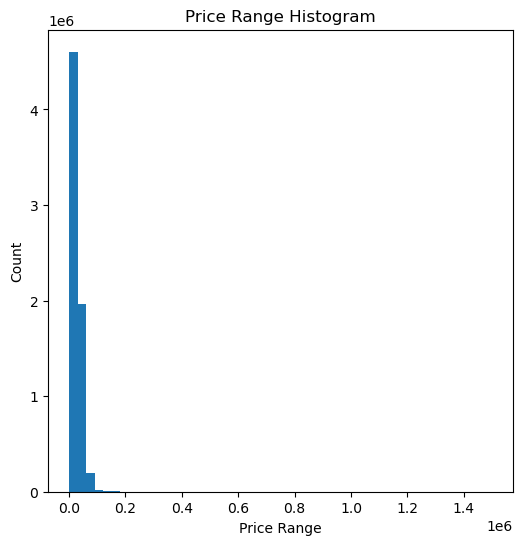

In [21]:
# Set up plot
plt.figure(figsize=(6,6))
# Plot
plt.hist(df["price"],bins=50)
# Plot title & axes
plt.title("Price Range Histogram")
plt.xlabel("Price Range")
plt.ylabel("Count")
# Show Plot
plt.show()

There are some extreme values on the right. Let's plot a box-whisker plot with log scale.

#### Plot a box-whisker plot with `price` column 

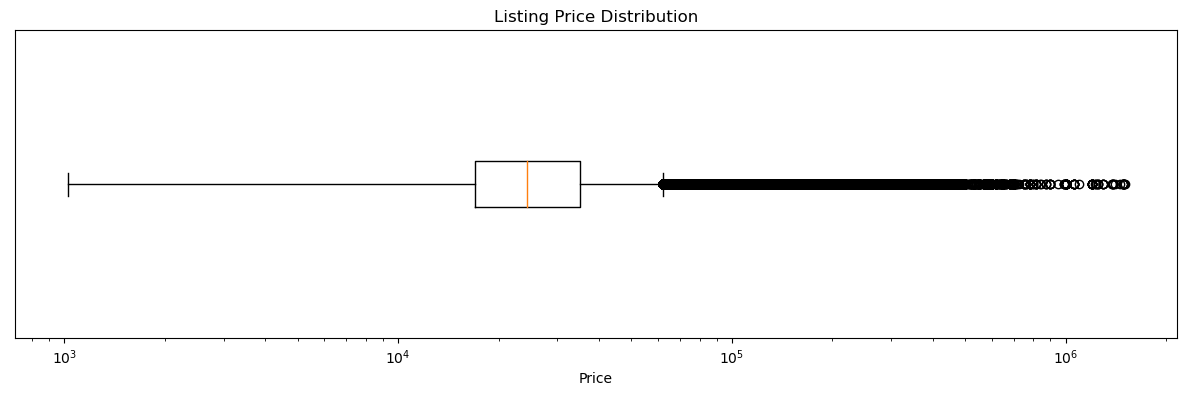

In [22]:
# Set up plot
plt.figure(figsize=(15,4))
# Plot
box = plt.boxplot(df["price"],vert=False)
# Plot title & axes
plt.title("Listing Price Distribution")
plt.xlabel("Price")
plt.yticks([]) # Remove y axis tick
plt.xscale("log")
# Show Plot
plt.show()

Even with a log scale on x-axis, we can see that there are a lot of extreme value on the right, these are the outlier for the `price` column.

In [23]:
upper_whisker = box['whiskers'][1].get_xdata()[1]
print(f"Ther upper whisker is ${upper_whisker}")

Ther upper whisker is $61982.0


#### Define range group for target variable `price`

Let's take an approximation of \\$60000 as a benchmark to be outlier classifier. Lising price over \\$60000 will be classified as the most expensive group(5). Followed by the following groups:
- Group 5: > \\$60,000
- Group 4: \\$45,000 - \\$59,999
- Group 3: \\$30,000 - \\$44,999
- Group 2: \\$15,000 - \\$29,999
- Group 1: \\$1,000 - \\$14,999

Now, our problem becomes a classification task which is solved by our machine learning and deep learning model.  
Let's do the labelling for `price` column.

#### Prepare a function for price labellin

In [24]:
# Function for target variable labelling
def price_label(price: float)-> int:
    """
    Description
    -----
    Function specific for target variable labeling. 
    Convert the exact price into price range.
    
    Labeling Logic:
    |-------------------------|-------|
    |        price range      | group |
    |-------------------------|-------|
    |        > 60,000.00      |   5   |
    |-------------------------|-------|
    |  45,000.00 - 59,999.99  |   4   |
    |-------------------------|-------|
    |  30,000.00 - 44,999.99  |   3   |
    |-------------------------|-------|
    |  15,000.00 - 29,999.99  |   2   |
    |-------------------------|-------|
    |        < 15,000.00      |   1   |
    |-------------------------|-------|
    
    Args
    -----
    price (float): the exact price
    
    Returns
    -----
    label (int): the price range group from 1 to 5
    
    Example
    -----
    price_label(43246.80) => 3
    price_label(59384.2) => 6
    
    """
    assert price >= 0, "'Price' cannot be negative number"
    if price >= 60000:
        return 5
    elif price >= 45000:
        return 4
    elif price >= 30000:
        return 3
    elif price >= 15000:
        return 2
    else:
        return 1

#### Target Variable Labelling

In [25]:
# Target Variable labelling
df['price_range'] = df['price'].apply(lambda p: price_label(p))

In [26]:
# Sanity Check
df.head()

,id,vin,price,miles,stock_no,year,make,model,trim,body_type,...,transmission,fuel_type,engine_size,engine_block,seller_name,street,city,state,zip,price_range
0,b39ea795-eca9,19UNC1B01HY800062,179999.0,9966.0,V-P4139,2017.0,Acura,NSX,Base,Coupe,...,Automatic,Electric / Premium Unleaded,3.5,V,edmundston honda,475 Rue Victoria,Edmundston,NB,E3V 2K7,5
1,026cb5b1-6e3e,19UNC1B02HY800023,179995.0,5988.0,PPAP70374,2017.0,Acura,NSX,Base,Coupe,...,Automatic,Electric / Premium Unleaded,3.5,V,garage daniel lessard,2795 Route-du-prsident-kennedy,Notre-dame-des-pins,QC,G0M 1K0,5
2,5cd5d5b2-5cc2,19UNC1B02HY800071,168528.0,24242.0,B21085,2017.0,Acura,NSX,Base,Coupe,...,Automatic,Electric / Premium Unleaded,3.5,V,lougheed acura,1388 Lougheed Highway,Coquitlam,BC,V3K 6S4,5
3,b32473ed-5922,19UNC1B02LY800001,220000.0,6637.0,AP5333,2020.0,Acura,NSX,Base,Coupe,...,Automatic,Electric / Premium Unleaded,3.5,V,drive autogroup,1305 Parkway Suite 600,Pickering,ON,L1V 3P2,5
4,ac40c9fc-0676,19UNC1B02LY800001,220000.0,6637.0,AP5333,2020.0,Acura,NSX,Base,Coupe,...,Automatic,Electric / Premium Unleaded,3.5,V,acura pickering,575 Kingston Road,Pickering,ON,L1V 3N7,5


#### Drop origin `price` column

In [27]:
df = drop_cols_if_exist(df,["price"])

Successfully dropped columns: {'price'}


In [28]:
# Double check the remaining columns
print(f"Remaining Columns: {df.columns}")

Remaining Columns: Index(['id', 'vin', 'miles', 'stock_no', 'year', 'make', 'model', 'trim',
       'body_type', 'vehicle_type', 'drivetrain', 'transmission', 'fuel_type',
       'engine_size', 'engine_block', 'seller_name', 'street', 'city', 'state',
       'zip', 'price_range'],
      dtype='object')


---

### Remove columns that may not be useful to our prediction. <a class="anchor" id="drop-useless"></a>

`id` is the unique id for each listing (record), it is not useful for our prediction.

`vin` is the unique id for each car, we will keep it as it may be helpful in feature engineering step. Listing history of the same car can be traced back if possible.

`stock_no` is the stock id of the car listed on the website, it is not useful for our prediction.

`seller_name` is the the name of the seller, it may not be useful for our prediction.

`street` is the the location of the seller, the location information can be retrieved from the zip code as well. But we will keep it here now. for data cleaning purpose.

In [29]:
columns_to_remove = ["id","stock_no","seller_name"]
df = drop_cols_if_exist(df,columns_to_remove)
print(f"Remaining Columns: {df.columns}")

Successfully dropped columns: {'stock_no', 'id', 'seller_name'}
Remaining Columns: Index(['vin', 'miles', 'year', 'make', 'model', 'trim', 'body_type',
       'vehicle_type', 'drivetrain', 'transmission', 'fuel_type',
       'engine_size', 'engine_block', 'street', 'city', 'state', 'zip',
       'price_range'],
      dtype='object')


In [30]:
df.head()

,vin,miles,year,make,model,trim,body_type,vehicle_type,drivetrain,transmission,fuel_type,engine_size,engine_block,street,city,state,zip,price_range
0,19UNC1B01HY800062,9966.0,2017.0,Acura,NSX,Base,Coupe,Car,4WD,Automatic,Electric / Premium Unleaded,3.5,V,475 Rue Victoria,Edmundston,NB,E3V 2K7,5
1,19UNC1B02HY800023,5988.0,2017.0,Acura,NSX,Base,Coupe,Car,4WD,Automatic,Electric / Premium Unleaded,3.5,V,2795 Route-du-prsident-kennedy,Notre-dame-des-pins,QC,G0M 1K0,5
2,19UNC1B02HY800071,24242.0,2017.0,Acura,NSX,Base,Coupe,Car,4WD,Automatic,Electric / Premium Unleaded,3.5,V,1388 Lougheed Highway,Coquitlam,BC,V3K 6S4,5
3,19UNC1B02LY800001,6637.0,2020.0,Acura,NSX,Base,Coupe,Car,4WD,Automatic,Electric / Premium Unleaded,3.5,V,1305 Parkway Suite 600,Pickering,ON,L1V 3P2,5
4,19UNC1B02LY800001,6637.0,2020.0,Acura,NSX,Base,Coupe,Car,4WD,Automatic,Electric / Premium Unleaded,3.5,V,575 Kingston Road,Pickering,ON,L1V 3N7,5


---

### Handle Null Value in Each Column <a class="anchor" id="null-col-check"></a>

In [31]:
print_null_count(df)

=== Null Count ===
vin                  0
miles            57777
year                92
make                 0
model             9720
trim             42796
body_type        50534
vehicle_type     62808
drivetrain       42903
transmission     38570
fuel_type        94785
engine_size     143713
engine_block    146977
street           35246
city             17946
state            18016
zip              18146
price_range          0
dtype: int64


---

### Column: `miles` <a class="anchor" id="col-miles"></a>

#### Null Value Check

In [32]:
# How many null value in this column
print_null_count(df,["miles"])

=== Null Count ===
Column `miles`: 57777


In [33]:
# Precentage of null value in this column
print_null_pct(df,["miles"])

=== Null Count Precentage ===
Column miles: 0.8489%


#### Question: How to deal with the null values?
- We can either use the mean or median value to replace all the null value.
- But which to use?

In [34]:
# Remove na from the series for plotting
df_miles = df["miles"]
df_miles_no_na =df_miles.dropna()

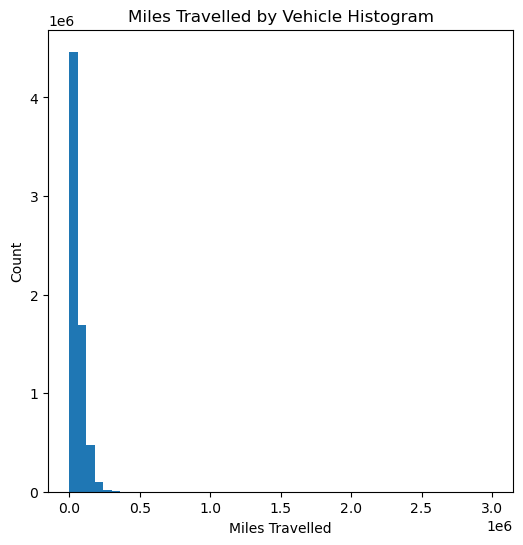

In [35]:
# Set up plot
plt.figure(figsize=(6,6))
# Plot
plt.hist(df_miles_no_na,bins=50)
# Plot title & axes
plt.title("Miles Travelled by Vehicle Histogram")
plt.xlabel("Miles Travelled")
plt.ylabel("Count")
# Show Plot
plt.show()

- It seems that the plot has some the outliers on the right. Now, we try to make a boxplot.

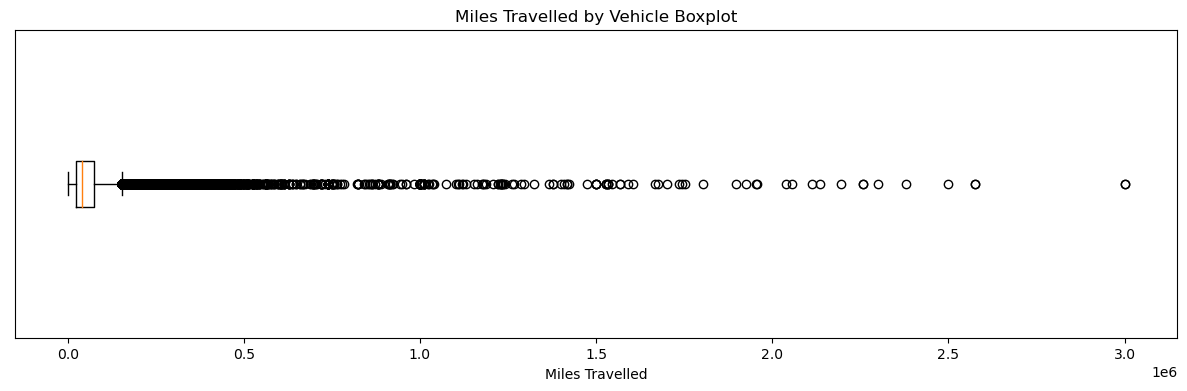

In [36]:
# Set up plot
plt.figure(figsize=(15,4))
# Plot
box = plt.boxplot(df_miles_no_na,vert=False)
# Plot title & axes
plt.title("Miles Travelled by Vehicle Boxplot")
plt.xlabel("Miles Travelled")
plt.yticks([]) # Remove y axis tick
# Show Plot
plt.show()

In [37]:
whiskers = [item.get_xdata()[1] for item in box["whiskers"]]
print(f"The range of the whiskers in the above plot is from {whiskers[0]} miles to {whiskers[1]} miles")

The range of the whiskers in the above plot is from 0.0 miles to 155436.0 miles


In [38]:
# Show the statistics of the `miles` column
miles_stats = df["miles"].describe()

In order to determine what to do with the null data, we focus on the range of the whisker.

In [39]:
mean = miles_stats["mean"]
med = miles_stats["50%"]

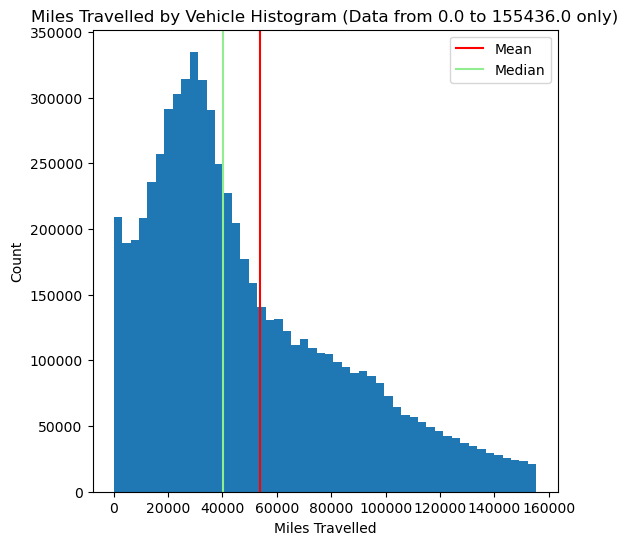

In [40]:
# Set up plot
plt.figure(figsize=(6,6))
# Plot
plt.hist(df_miles_no_na[(df_miles_no_na>=whiskers[0])&(df_miles_no_na<= whiskers[1])],bins=50)
# Plot vertical line for mean and median
plt.axvline(mean,color = "red",label = "Mean")
plt.axvline(med,color = "lightgreen",label = "Median")
# Plot title & axes
plt.title(f"Miles Travelled by Vehicle Histogram (Data from {whiskers[0]} to {whiskers[1]} only)")
plt.xlabel("Miles Travelled")
plt.ylabel("Count")
plt.legend()
# Show Plot
plt.show()

- As we have so many outliers from the boxplot above and the median is closer to the peak of the data than that of mean, I will use the median to fill in the null value.

#### Fill Null Value

In [41]:
# Fill the null value with median
df["miles"].fillna(med,inplace=True)

##### Double check null value count

In [42]:
# Check any null value in `miles` column
print_null_count(df,["miles"])

=== Null Count ===
Column `miles`: 0


---

### Column: `year` <a class="anchor" id="col-year"></a>

#### Null Value Check

In [43]:
# How many null value in this column
print_null_count(df,["year"])

=== Null Count ===
Column `year`: 92


In [44]:
# Precentage of null value in this column
print_null_pct(df,["year"])

=== Null Count Precentage ===
Column year: 0.0014%


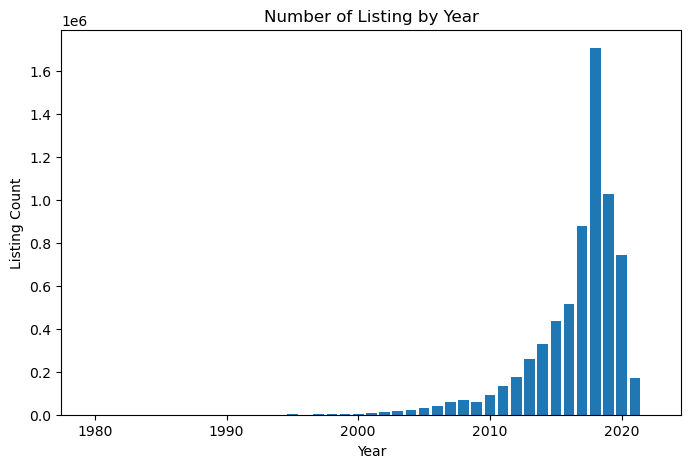

In [45]:
year_series = df['year']
year_val_count = year_series.value_counts()

# Set up plt
plt.figure(figsize=(8,5))
# Plot
plt.bar(year_val_count.index, year_val_count.values)
# Plot Title & Axes
plt.title("Number of Listing by Year")
plt.xlabel("Year")
plt.ylabel("Listing Count")
# Show Plot
plt.show()

#### Question: How to deal with the null values?
- As we can see from the plot, the number of listing **increase exponentially**, which matches with the exponential growth in automobile industries and the rise of e-platform for these kind of dealer service. 
- Consider this scenario and **the number of null value is very small (0.0014% of total)**, it is better not to guess the `year` of the listing record with null `year` value.  
- Instead, we **drop** them away.

#### Drop rows without `year`

In [46]:
# Drop row that have null value in `year`
df.dropna(subset=["year"],inplace = True)

# Check number of data left after dropping
print_num_row(df)

The dataframe has 6805796 rows of record now.


---

### Column: `model`  <a class="anchor" id="col-model"></a>

#### Null Value Check

In [47]:
# How many null value in this column
print_null_count(df,["model"])

=== Null Count ===
Column `model`: 9681


In [48]:
# Precentage of null value in this column
print_null_pct(df,["model"])

=== Null Count Precentage ===
Column model: 0.1422%


In [49]:
# Apply value_count in the column
target_col_val_count = df["model"].value_counts()
target_col_val_count

F-150              241837
Silverado 1500     183232
Ram 1500 Pickup    140323
CR-V               135020
Escape             117744
                    ...  
GS 300                  1
300sd                   1
CBR900RR                1
Vanagon                 1
Bronco 2-Door           1
Name: model, Length: 1251, dtype: int64

In [50]:
print(f"There are {len(target_col_val_count)} distinct value in `model` column.")

There are 1251 distinct value in `model` column.


#### Question: How to deal with the null values?
- As the null percentage of the column `model` is only 0.14%, we can fill them up with `Not Provided` first.
- As there are many distinct values in this column, we may handle them later in the EDA section.

#### Fill Null Value

In [51]:
# Fill NA with "Not Provided"
df["model"] = df["model"].fillna(value="Not Provided")

##### Double check null value count

In [52]:
# Check number of null value
print_null_count(df,["model"])

=== Null Count ===
Column `model`: 0


In [53]:
# Double Check "Not provided" count
df["model"].value_counts()['Not Provided']

9681

---

### Column: `trim`  <a class="anchor" id="col-trim"></a>

#### Null Value Check

In [54]:
# How many null value in this column
print_null_count(df,["trim"])

=== Null Count ===
Column `trim`: 42766


In [55]:
# Precentage of null value in this column
print_null_pct(df,["trim"])

=== Null Count Precentage ===
Column trim: 0.6284%


In [56]:
# Apply value_count in the column
target_col_val_count = df["trim"].value_counts()
target_col_val_count

SE                  401087
Base                341931
Limited             313880
LT                  265268
S                   255824
                     ...  
Premiere Edition         1
Ext. Cab 4WD             1
735i Automatic           1
SPECIAL ED               1
R63 AMG                  1
Name: trim, Length: 2491, dtype: int64

In [57]:
print(f"There are {len(target_col_val_count)} distinct value in `trim` column.")

There are 2491 distinct value in `trim` column.


#### Question: How to deal with the null values?
- As the null percentage of the column `trim` is 0.62%, we can fill them up with `Not Provided` first.
- As there are many distinct values in this column, we may handle them later in the EDA section.

#### Fill Null Value

In [58]:
# Fill NA with "Not Provided"
df["trim"] = df["trim"].fillna(value="Not Provided")

##### Double check null value count

In [59]:
# Check number of null value
print_null_count(df,["trim"])

=== Null Count ===
Column `trim`: 0


In [60]:
# Double Check "Not provided" count
df["trim"].value_counts()['Not Provided']

42766

---

### Column: `body_type` <a class="anchor" id="col-body-type"></a>

#### Null Value Check

In [61]:
# How many null value in this column
print_null_count(df,["body_type"])

=== Null Count ===
Column `body_type`: 50447


In [62]:
# Precentage of null value in this column
print_null_pct(df,["body_type"])

=== Null Count Precentage ===
Column body_type: 0.7412%


In [63]:
# Apply value_count in the column
target_col_val_count = df["body_type"].value_counts()
target_col_val_count

SUV                 2719454
Sedan               1730741
Pickup              1056227
Crossover            357683
Hatchback            306657
Coupe                221737
Minivan              139761
Wagon                 76534
Convertible           55197
Cargo Van             46585
Roadster              11244
Mini Mpv               9427
Chassis Cab            8989
Passenger Van          7207
Targa                  2778
Cutaway                2207
Combi                   936
Van                     736
Micro Car               721
Car Van                 498
Commercial Wagon         26
Chassis Cowl              4
Name: body_type, dtype: int64

In [64]:
print(f"There are {len(target_col_val_count)} distinct value in `body_type` column.")

There are 22 distinct value in `body_type` column.


#### Question: How to deal with the null values?
- As the null percentage of the column `body_type` is 0.74%, we can fill them up with `Not Provided` first.
- As there are many distinct values in this column, we may handle them later in the EDA section.

#### Fill Null Value

In [65]:
# Fill NA with "Not Provided"
df["body_type"] = df["body_type"].fillna(value="Not Provided")

##### Double check null value count

In [66]:
# Check number of null value
print_null_count(df,["body_type"])

=== Null Count ===
Column `body_type`: 0


In [67]:
# Double Check "Not provided" count
df["body_type"].value_counts()['Not Provided']

50447

---

### Column: `vehicle_type`  <a class="anchor" id="col-vehicle-type"></a>

#### Null Value Check

In [68]:
# How many null value in this column
print_null_count(df,["vehicle_type"])

=== Null Count ===
Column `vehicle_type`: 62717


In [69]:
# Precentage of null value in this column
print_null_pct(df,["vehicle_type"])

=== Null Count Precentage ===
Column vehicle_type: 0.9215%


In [70]:
# Check value_count in the column
target_col_val_count = df["vehicle_type"].value_counts()
target_col_val_count

Truck    4317492
Car      2425587
Name: vehicle_type, dtype: int64

In [71]:
print(f"There are {len(target_col_val_count)} distinct value in `vehicle_type` column.")

There are 2 distinct value in `vehicle_type` column.


In [72]:
# Check value_count percentage in the column
target_col_val_count = df["vehicle_type"].value_counts()
target_col_val_count / df.shape[0]*100

Truck    63.438457
Car      35.640019
Name: vehicle_type, dtype: float64

#### Question: How to deal with the null values?
- As we have only 2 values in this column, which are `truck` and `car`. 
- To avoid create a categorical column with more than 2 labels and reduce the possibility of class imbalance, we can fill the NA value with `Car`.
- This is reasonable as we can assume that the used vehicle in the dataset should be `Car` by default.

#### Fill Null Value

In [73]:
# Fill NA with "Not Provided"
df["vehicle_type"] = df["vehicle_type"].fillna(value="Car")

##### Double check null value count

In [74]:
# Check number of null value
print_null_count(df,["vehicle_type"])

=== Null Count ===
Column `vehicle_type`: 0


In [75]:
# Double check value_count in the column
target_col_val_count = df["vehicle_type"].value_counts()
target_col_val_count

Truck    4317492
Car      2488304
Name: vehicle_type, dtype: int64

In [76]:
# Double check value_count percentage in the column
target_col_val_count = df["vehicle_type"].value_counts()
target_col_val_count / df.shape[0]*100

Truck    63.438457
Car      36.561543
Name: vehicle_type, dtype: float64

- The ratio of the `Truck` and `Car` are around 63:37, it is still aceptable.

---

### Column: `drivetrain` <a class="anchor" id="col-drivetrain"></a>

#### Null Value Check

In [77]:
# How many null value in this column
print_null_count(df,["drivetrain"])

=== Null Count ===
Column `drivetrain`: 42824


In [78]:
# Precentage of null value in this column
print_null_pct(df,["drivetrain"])

=== Null Count Precentage ===
Column drivetrain: 0.6292%


In [79]:
# Check value_count in the column
target_col_val_count = df["drivetrain"].value_counts()
target_col_val_count

4WD    3426425
FWD    2548947
RWD     787600
Name: drivetrain, dtype: int64

In [80]:
print(f"There are {len(target_col_val_count)} distinct value in `drivetrain` column.")

There are 3 distinct value in `drivetrain` column.


#### Question: Is it possible to guess the `drivetrain` type by the year of the model, the model and the maker of the car?

- The possible guess is that the same car model built by the same maker in the same year should have the same `drivetrain` type.
- For some models, they may have different `drivetrain` types. If that is the case, we can guess their `drivetrain` type based on the occurrence grouped by the `year`, `make` and `model`, and then calculate their corresponding probabilities.
- Lastly, we randomly selected the `drivetrain` type based on their probabilities.

In [81]:
# Create a temporary dataframe for this part
temp_df = df[["year","make","model","drivetrain"]]
temp_df.head()

,year,make,model,drivetrain
0,2017.0,Acura,NSX,4WD
1,2017.0,Acura,NSX,4WD
2,2017.0,Acura,NSX,4WD
3,2020.0,Acura,NSX,4WD
4,2020.0,Acura,NSX,4WD


##### Group the `year`, `make` and `model` as one column

In [82]:
# Create columns that aggregate the `year`, `make` and `model`
# Note: "year" column is in float format. 
# `astype(int)` transform the year from float to int
# Then, `astype(str)` transform the year from int to str for concatenation 
temp_df["year-make-model"] = df["year"].astype(int).astype(str) + "-" + df["make"] + "-" + df["model"]
temp_df.head()

/Users/anthonykwok/anaconda3/envs/bs-capstone/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,year,make,model,drivetrain,year-make-model
0,2017.0,Acura,NSX,4WD,2017-Acura-NSX
1,2017.0,Acura,NSX,4WD,2017-Acura-NSX
2,2017.0,Acura,NSX,4WD,2017-Acura-NSX
3,2020.0,Acura,NSX,4WD,2020-Acura-NSX
4,2020.0,Acura,NSX,4WD,2020-Acura-NSX


##### Count drivetrain occurrence

In [83]:
# Count how the occurrence of `drivetrain` for each `year-make-model` combination
year_make_model_drivetrain_count = \
    temp_df\
    .groupby(["year-make-model","drivetrain"])["drivetrain"]\
    .count()\
    .unstack()\
    .fillna(0)\
    .reset_index(drop = False)\
    .set_index(keys = ["year-make-model"])
year_make_model_drivetrain_count.tail()

drivetrain,4WD,FWD,RWD
year-make-model,,,
2022-MINI-Cooper,0.0,48.0,0.0
2022-MINI-Countryman,0.0,22.0,0.0
2022-MINI-Hardtop 4 Door,0.0,98.0,0.0
2022-Mitsubishi-Eclipse Cross,2.0,6.0,0.0
2022-Mitsubishi-Outlander,5.0,2.0,0.0


##### Convert into probability by normalization

In [84]:
# Get the normalized version for the probability
year_make_model_drivetrain_prob = \
    year_make_model_drivetrain_count.div(year_make_model_drivetrain_count.sum(axis=1), axis=0)
year_make_model_drivetrain_prob = year_make_model_drivetrain_prob.T.to_dict()

##### Group the `make` and `model` as one column

In [85]:
# Create columns that aggregate the `make` and `model`
temp_df["make-model"] = df["make"] + "-" + df["model"]
temp_df.head()

/Users/anthonykwok/anaconda3/envs/bs-capstone/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,year,make,model,drivetrain,year-make-model,make-model
0,2017.0,Acura,NSX,4WD,2017-Acura-NSX,Acura-NSX
1,2017.0,Acura,NSX,4WD,2017-Acura-NSX,Acura-NSX
2,2017.0,Acura,NSX,4WD,2017-Acura-NSX,Acura-NSX
3,2020.0,Acura,NSX,4WD,2020-Acura-NSX,Acura-NSX
4,2020.0,Acura,NSX,4WD,2020-Acura-NSX,Acura-NSX


##### Count drivetrain occurrence

In [86]:
# Count how the occurrence of `drivetrain` for each `make-model` combination
make_model_drivetrain_count = \
    temp_df\
    .groupby(["make-model","drivetrain"])["drivetrain"]\
    .count()\
    .unstack()\
    .fillna(0)\
    .reset_index(drop = False)\
    .set_index(keys = ["make-model"])
make_model_drivetrain_count.tail()

drivetrain,4WD,FWD,RWD
make-model,,,
Volvo-XC60,12253.0,1941.0,0.0
Volvo-XC70,804.0,162.0,0.0
Volvo-XC90,12894.0,1916.0,0.0
smart-Sorento,1.0,0.0,0.0
smart-fortwo,0.0,0.0,1487.0


##### Convert into probability by normalization

In [87]:
# Get the normalized version for the probability
make_model_drivetrain_prob = \
    make_model_drivetrain_count.div(make_model_drivetrain_count.sum(axis=1), axis=0)
make_model_drivetrain_prob = make_model_drivetrain_prob.T.to_dict()

##### Count drivetrain occurrence in original df

In [88]:
# Prepare the probability for random assignment if the combination is not found in both tables above.
drivetrain_val_count = df["drivetrain"].value_counts().to_frame()
drivetrain_val_count

,drivetrain
4WD,3426425
FWD,2548947
RWD,787600


##### Convert into probability by normalization

In [89]:
# Prepare the probability for general selection
drivetrain_val_prob = drivetrain_val_count.div(drivetrain_val_count.sum(axis=0),axis=1)
drivetrain_val_prob = drivetrain_val_prob.to_dict()['drivetrain']
drivetrain_val_prob

{'4WD': 0.5066448596859487,
 'FWD': 0.3768974646057976,
 'RWD': 0.1164576757082537}

##### Function to fill NA

In [90]:


def fill_na_by_year_make_model(df: pd.DataFrame,
                               column_to_fill: str,
                               year_make_model_prob: dict,
                               make_model_prob: dict,
                               random_prob: dict,
                               inplace = True):
    """
    Description
    -----
    This function is designed for filling the null value based of the occurrence and probability of the combination of `year`, `make` and `model`.
    If the key (`year`, `make`, `model`) is not found in `year_make_model_prob` then search for 
    the subkey (`make`, `model`) in `make_model_prob`. If not found,
    use the occurrence probability of the distinct value in the `column_to_fill` in `random_prob`.
    
    Then, select one of the dictinst values from the `column_to_fill` based on the probability retrieved above.
    
    Args
    -----
    df (pd.DataFrame): the original dataframe
    column_to_fill (str): our target column to fill the null value
    year_make_model_prob (dict): a dictionary with the key of each (`year`, `make`, `model`) combination and 
                                 value of the probabilities of the values in the target column
    make_model_prob (dict): a dictionary with the key of each (`make`, `model`) combination and 
                            value of the probabilities of the values in the target column
    random_prob (dict):  a dictionary with the key of each value in the target column and 
                            value of the probabilities of each value
    inplace (boolean): whether to fill the null value in the original dataframe. Use `False` for deubgging purpose. Default: `True`. 
    
    Returns
    -----
    None
        
    
    """
    
    # Validation
    assert column_to_fill in df.columns, "'column_to_fill' must be one of the column names in 'df'."
    
    # Get total null count
    total_null_count = df[column_to_fill].isna().sum()
    
    # Variable for counting how many rows filled
    i_count = 0
    
    # Implement cache to speed up search
    year_make_model_cache = {}
    make_model_cache = {}
    general_cache=[]
    general_cache_filled = False
    
    # New list to store the new data
    index_list = []
    target_col_list = []
    
    # Iterate through all rows with null value in `column_to_fill`
    for ind, row in df[df[column_to_fill].isna()].iterrows():
        
        # Construct the key and sub_key for search
        key = str(int(row["year"]))+"-"+row["make"]+"-"+row["model"]
        sub_key = row["make"]+"-"+row["model"]

        # If year-make-model key is found in cache
        if key in year_make_model_cache:
            
            # Retrieve the choice
            choice = year_make_model_cache[key][0]
            # Retrieve the probability
            prob = year_make_model_cache[key][1]
            # Selected one of the available option based on the probability
            selected = np.random.choice(choice,
                                        p=prob)
            
        # If the key is not in cache, search the index from original dict  
        elif key in year_make_model_prob:

            # Retrieve the choice
            choice = list(year_make_model_prob[key].keys())
            # Retrieve the probability
            prob = list(year_make_model_prob[key].values())
            # Selected one of the available option based on the probability
            selected = np.random.choice(choice,
                                        p=prob)
            # Save it in cache
            year_make_model_cache[key] = [choice,prob]

        # If year-make-model key is NOT found, Go to sub_key
        else:
            
            # If make-model key is found in cache
            if sub_key in make_model_cache:
                # Retrieve the choice
                choice = make_model_cache[sub_key][0]
                # Retrieve the probability
                prob = make_model_cache[sub_key][1]
                # Selected one of the available option based on the probability
                selected = np.random.choice(choice,
                                            p=prob)
            
            # Try search with make-model key from original dict
            if sub_key in make_model_prob:
                
                # Retrieve the choice
                choice = list(make_model_prob[sub_key].keys())
                # Retrieve the probability
                prob = list(make_model_prob[sub_key].values())
                # Selected one of the available option based on the probability
                selected = np.random.choice(choice,
                                            p=prob)
                # Save it in cache
                make_model_cache[sub_key] = [choice,prob]
            
            # If make-model key is NOT found, Go to general selection
            else:
                # If general selection cache is found
                if general_cache_filled:
                    
                    # Retrieve the choice
                    choice = general_cache[0]
                    # Retrieve the probability
                    prob = general_cache[1]
                    # Selected one of the available option based on the probability
                    selected = np.random.choice(choice,
                                                p=prob)
                    
                else:
                    # Retrieve the choice
                    choice = list(random_prob.keys())
                    # Retrieve the probability
                    prob = list(random_prob.values())
                    # Selected one of the available option based on the probability
                    selected = np.random.choice(choice,
                                                p=prob)
                    
                    # Save it in general_cache
                    general_cache = [choice, prob]
                    general_cache_filled = True
                    
        
        
        # Store the index and data in a list first
        index_list.append(ind)
        target_col_list.append(selected)
    
        
        i_count += 1
        if i_count % 5000 == 0:
            print(f"Filled rows: {i_count} / {total_null_count}")
          
    # Convert the data into df and store it back to original df
    new_df = pd.DataFrame({column_to_fill:target_col_list},index=index_list)
    if inplace:
        df.loc[index_list,column_to_fill] = new_df.loc[index_list,column_to_fill]
    else:
        print(new_df.tail())
    print(f"Filling completed!Filled rows: {i_count} / {total_null_count}")
    

#### Fill Null Value

In [91]:
# How many null value in this column
print_null_count(df,["drivetrain"])


=== Null Count ===
Column `drivetrain`: 42824


In [92]:
%%timeit -n 1 -r 1  # time the execution

# Fill the NA with the function above
fill_na_by_year_make_model(df,
                           "drivetrain",
                           year_make_model_drivetrain_prob,
                           make_model_drivetrain_prob,
                           drivetrain_val_prob,
                           inplace=True)

Filled rows: 5000 / 42824
Filled rows: 10000 / 42824
Filled rows: 15000 / 42824
Filled rows: 20000 / 42824
Filled rows: 25000 / 42824
Filled rows: 30000 / 42824
Filled rows: 35000 / 42824
Filled rows: 40000 / 42824
Filling completed!Filled rows: 42824 / 42824
5.37 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


##### Double check null value count

In [93]:
# How many null value in this column after filling NA
print_null_count(df,["drivetrain"])

=== Null Count ===
Column `drivetrain`: 0


---

### Column: `transmission` <a class="anchor" id="col-transmission"></a>

#### Null Value Check

In [94]:
# How many null value in this column
print_null_count(df,["transmission"])

=== Null Count ===
Column `transmission`: 38522


In [95]:
# Precentage of null value in this column
print_null_pct(df,["transmission"])

=== Null Count Precentage ===
Column transmission: 0.566%


In [96]:
# Check value_count in the column
target_col_val_count = df["transmission"].value_counts()
target_col_val_count

Automatic    6324765
Manual        442509
Name: transmission, dtype: int64

In [97]:
print(f"There are {len(target_col_val_count)} distinct value in `transmission` column.")

There are 2 distinct value in `transmission` column.


#### Question: Is it possible to guess the `transmission` type by the year of the model, the model and the maker of the car? 


- Similar to `drivetrain`, we can apply the same method to `transmission` type.
- The possible guess is that the same car model built by the same maker in the same year should have the same `transmission` type.
- For some models, they may have different `transmission` types. If that is the case, we can guess their `transmission` type based on the occurrence grouped by the `year`, `make` and `model`, and then calculate their corresponding probabilities.
- Lastly, we randomly selected the `transmission` type based on their probabilities.

In [98]:
# Create a temporary dataframe for this part
temp_df = df[["year","make","model","transmission"]]
temp_df.head()

,year,make,model,transmission
0,2017.0,Acura,NSX,Automatic
1,2017.0,Acura,NSX,Automatic
2,2017.0,Acura,NSX,Automatic
3,2020.0,Acura,NSX,Automatic
4,2020.0,Acura,NSX,Automatic


##### Group the `year`, `make` and `model` as one column

In [99]:
# Create columns that aggregate the `year`, `make` and `model`
# Note: "year" column is in float format. 
# `astype(int)` transform the year from float to int
# Then, `astype(str)` transform the year from int to str for concatenation 
temp_df["year-make-model"] = df["year"].astype(int).astype(str) + "-" + df["make"] + "-" + df["model"]
temp_df.head()

/Users/anthonykwok/anaconda3/envs/bs-capstone/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,year,make,model,transmission,year-make-model
0,2017.0,Acura,NSX,Automatic,2017-Acura-NSX
1,2017.0,Acura,NSX,Automatic,2017-Acura-NSX
2,2017.0,Acura,NSX,Automatic,2017-Acura-NSX
3,2020.0,Acura,NSX,Automatic,2020-Acura-NSX
4,2020.0,Acura,NSX,Automatic,2020-Acura-NSX


##### Count transmission occurrence

In [100]:
# Count how the occurrence of `transmission` for each `year-make-model` combination
year_make_model_transmission_count = \
    temp_df\
    .groupby(["year-make-model","transmission"])["transmission"]\
    .count()\
    .unstack()\
    .fillna(0)\
    .reset_index(drop = False)\
    .set_index(keys = ["year-make-model"])
year_make_model_transmission_count.tail()

transmission,Automatic,Manual
year-make-model,,
2022-MINI-Cooper,0.0,48.0
2022-MINI-Countryman,22.0,0.0
2022-MINI-Hardtop 4 Door,0.0,98.0
2022-Mitsubishi-Eclipse Cross,8.0,0.0
2022-Mitsubishi-Outlander,7.0,0.0


##### Convert into probability by normalization

In [101]:
# Get the normalized version for the probability
year_make_model_transmission_prob = \
    year_make_model_transmission_count.div(year_make_model_transmission_count.sum(axis=1), axis=0)
year_make_model_transmission_prob = year_make_model_transmission_prob.T.to_dict()

##### Group the `make` and `model` as one column

In [102]:
# Create columns that aggregate the `make` and `model`
temp_df["make-model"] = df["make"] + "-" + df["model"]
temp_df.head()

/Users/anthonykwok/anaconda3/envs/bs-capstone/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,year,make,model,transmission,year-make-model,make-model
0,2017.0,Acura,NSX,Automatic,2017-Acura-NSX,Acura-NSX
1,2017.0,Acura,NSX,Automatic,2017-Acura-NSX,Acura-NSX
2,2017.0,Acura,NSX,Automatic,2017-Acura-NSX,Acura-NSX
3,2020.0,Acura,NSX,Automatic,2020-Acura-NSX,Acura-NSX
4,2020.0,Acura,NSX,Automatic,2020-Acura-NSX,Acura-NSX


##### Count transmission occurrence

In [103]:
# Count how the occurrence of `transmission` for each `make-model` combination
make_model_transmission_count = \
    temp_df\
    .groupby(["make-model","transmission"])["transmission"]\
    .count()\
    .unstack()\
    .fillna(0)\
    .reset_index(drop = False)\
    .set_index(keys = ["make-model"])
make_model_transmission_count.head()

transmission,Automatic,Manual
make-model,,
Acura-500,1.0,0.0
Acura-A5,3.0,0.0
Acura-CL,69.0,1.0
Acura-CSX,3.0,0.0
Acura-Coupe,0.0,2.0


##### Convert into probability by normalization

In [104]:
# Get the normalized version for the probability
make_model_transmission_prob = \
    make_model_transmission_count.div(make_model_transmission_count.sum(axis=1), axis=0)
make_model_transmission_prob = make_model_transmission_prob.T.to_dict()

##### Count transmission occurrence in original df

In [105]:
# Prepare the probability for random assignment if the combination is not found in both tables above.
transmission_val_count = df["transmission"].value_counts().to_frame()
transmission_val_count

,transmission
Automatic,6324765
Manual,442509


##### Convert into probability by normalization

In [106]:
# Prepare the probability for general selection
transmission_val_prob = transmission_val_count.div(transmission_val_count.sum(axis=0),axis=1)
transmission_val_prob = transmission_val_prob.to_dict()['transmission']
transmission_val_prob

{'Automatic': 0.9346104502344666, 'Manual': 0.06538954976553336}

#### Fill Null Value

In [107]:
# How many null value in this column
print_null_count(df,["transmission"])

=== Null Count ===
Column `transmission`: 38522


In [108]:
%%timeit -n 1 -r 1  # time the execution

# Fill the NA with the function above
fill_na_by_year_make_model(df,
                           "transmission",
                           year_make_model_transmission_prob,
                           make_model_transmission_prob,
                           transmission_val_prob)

Filled rows: 5000 / 38522
Filled rows: 10000 / 38522
Filled rows: 15000 / 38522
Filled rows: 20000 / 38522
Filled rows: 25000 / 38522
Filled rows: 30000 / 38522
Filled rows: 35000 / 38522
Filling completed!Filled rows: 38522 / 38522
4.04 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


##### Double check null value count

In [109]:
# How many null value in this column after filling NA
print_null_count(df,["transmission"])

=== Null Count ===
Column `transmission`: 0


---

### Column: `fuel_type` <a class="anchor" id="col-fuel-type"></a>

#### Null Value Check

In [110]:
# How many null value in this column
print_null_count(df,["fuel_type"])

=== Null Count ===
Column `fuel_type`: 94693


In [111]:
# Precentage of null value in this column
print_null_pct(df,["fuel_type"])

=== Null Count Precentage ===
Column fuel_type: 1.3914%


In [112]:
# Check value_count in the column
target_col_val_count = df["fuel_type"].value_counts()
target_col_val_count

Unleaded                                            4438817
Premium Unleaded                                    1401681
E85 / Unleaded                                       479776
Diesel                                               159266
Electric / Unleaded                                  117022
Electric / Premium Unleaded                           30088
Electric                                              21950
E85 / Premium Unleaded                                18851
E85 / Unleaded; Unleaded / Unleaded                   17057
Premium Unleaded; Unleaded                             8238
E85 / Unleaded; Unleaded                               4791
E85                                                    3704
Unleaded / Unleaded                                    2873
Premium Unleaded / Unleaded                            2072
Unleaded / E85                                         1644
E85 / Unleaded; Premium Unleaded                        769
Biodiesel                               

In [113]:
print(f"There are {len(target_col_val_count)} distinct value in `fuel_type` column.")

There are 38 distinct value in `fuel_type` column.


- There are different values in this column. Some of them are duplicated. Let's get all the distict fuel types.

#### Question: Is it possible to guess the `fuel_type` type by the year of the model, the model and the maker of the car? 

- Similar to `drivetrain` and `transmissionn`, we can apply the same method to `fuel_type` type.
- The possible guess is that the same car model built by the same maker in the same year should have the same `fuel_type` type.
- For some models, they may have different `fuel_type` types. If that is the case, we can guess their `fuel_type` type based on the occurrence grouped by the `year`, `make` and `model`, and then calculate their corresponding probabilities.
- Lastly, we randomly selected the `fuel_type` type based on their probabilities.

In [114]:
# Create a temporary dataframe for this part
temp_df = df[["year","make","model","fuel_type"]]
temp_df.head()

,year,make,model,fuel_type
0,2017.0,Acura,NSX,Electric / Premium Unleaded
1,2017.0,Acura,NSX,Electric / Premium Unleaded
2,2017.0,Acura,NSX,Electric / Premium Unleaded
3,2020.0,Acura,NSX,Electric / Premium Unleaded
4,2020.0,Acura,NSX,Electric / Premium Unleaded


##### Group the `year`, `make` and `model` as one column

In [115]:
# Create columns that aggregate the `year`, `make` and `model`
# Note: "year" column is in float format. 
# `astype(int)` transform the year from float to int
# Then, `astype(str)` transform the year from int to str for concatenation 
temp_df["year-make-model"] = df["year"].astype(int).astype(str) + "-" + df["make"] + "-" + df["model"]
temp_df.head()

/Users/anthonykwok/anaconda3/envs/bs-capstone/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,year,make,model,fuel_type,year-make-model
0,2017.0,Acura,NSX,Electric / Premium Unleaded,2017-Acura-NSX
1,2017.0,Acura,NSX,Electric / Premium Unleaded,2017-Acura-NSX
2,2017.0,Acura,NSX,Electric / Premium Unleaded,2017-Acura-NSX
3,2020.0,Acura,NSX,Electric / Premium Unleaded,2020-Acura-NSX
4,2020.0,Acura,NSX,Electric / Premium Unleaded,2020-Acura-NSX


##### Count fuel_type occurrence

In [116]:
# Count how the occurrence of `fuel_type` for each `year-make-model` combination
year_make_model_fuel_type_count = \
    temp_df\
    .groupby(["year-make-model","fuel_type"])["fuel_type"]\
    .count()\
    .unstack()\
    .fillna(0)\
    .reset_index(drop = False)\
    .set_index(keys = ["year-make-model"])
year_make_model_fuel_type_count.tail()

fuel_type,Biodiesel,Compressed Natural Gas,Compressed Natural Gas / Lpg,Compressed Natural Gas / Unleaded,Compressed Natural Gas; Unleaded,Diesel,Diesel / Premium Unleaded,Diesel; E85 / Unleaded,Diesel; Unleaded,E85,...,Premium Unleaded / E85,Premium Unleaded / Unleaded,Premium Unleaded; Premium Unleaded / E85,Premium Unleaded; Unleaded,Unleaded,Unleaded / E85,Unleaded / Electric,Unleaded / Premium Unleaded,Unleaded / Unleaded,Unleaded; Unleaded / E85
year-make-model,,,,,,,,,,,,,,,,,,,,,
2022-MINI-Cooper,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-MINI-Countryman,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-MINI-Hardtop 4 Door,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-Mitsubishi-Eclipse Cross,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0
2022-Mitsubishi-Outlander,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0


##### Convert into probability by normalization

In [117]:
# Get the normalized version for the probability
year_make_model_fuel_type_prob = \
    year_make_model_fuel_type_count.div(year_make_model_fuel_type_count.sum(axis=1), axis=0)
year_make_model_fuel_type_prob = year_make_model_fuel_type_prob.T.to_dict()

##### Group the `make` and `model` as one column

In [118]:
# Create columns that aggregate the  `make` and `model`
temp_df["make-model"] = df["make"] + "-" + df["model"]
temp_df.head()

/Users/anthonykwok/anaconda3/envs/bs-capstone/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,year,make,model,fuel_type,year-make-model,make-model
0,2017.0,Acura,NSX,Electric / Premium Unleaded,2017-Acura-NSX,Acura-NSX
1,2017.0,Acura,NSX,Electric / Premium Unleaded,2017-Acura-NSX,Acura-NSX
2,2017.0,Acura,NSX,Electric / Premium Unleaded,2017-Acura-NSX,Acura-NSX
3,2020.0,Acura,NSX,Electric / Premium Unleaded,2020-Acura-NSX,Acura-NSX
4,2020.0,Acura,NSX,Electric / Premium Unleaded,2020-Acura-NSX,Acura-NSX


##### Count transmission occurrence

In [119]:
# Count how the occurrence of `fuel_type` for each `make-model` combination
make_model_fuel_type_count = \
    temp_df\
    .groupby(["make-model","fuel_type"])["fuel_type"]\
    .count()\
    .unstack()\
    .fillna(0)\
    .reset_index(drop = False)\
    .set_index(keys = ["make-model"])
make_model_fuel_type_count.tail()

fuel_type,Biodiesel,Compressed Natural Gas,Compressed Natural Gas / Lpg,Compressed Natural Gas / Unleaded,Compressed Natural Gas; Unleaded,Diesel,Diesel / Premium Unleaded,Diesel; E85 / Unleaded,Diesel; Unleaded,E85,...,Premium Unleaded / E85,Premium Unleaded / Unleaded,Premium Unleaded; Premium Unleaded / E85,Premium Unleaded; Unleaded,Unleaded,Unleaded / E85,Unleaded / Electric,Unleaded / Premium Unleaded,Unleaded / Unleaded,Unleaded; Unleaded / E85
make-model,,,,,,,,,,,,,,,,,,,,,
Volvo-XC40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Volvo-XC60,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2632.0,0.0,0.0,0.0,0.0,0.0
Volvo-XC70,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,294.0,0.0,0.0,0.0,0.0,0.0
Volvo-XC90,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
smart-fortwo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### Convert into probability by normalization

In [120]:
# Get the normalized version for the probability
make_model_fuel_type_prob = \
    make_model_fuel_type_count.div(make_model_fuel_type_count.sum(axis=1), axis=0)
make_model_fuel_type_prob = make_model_fuel_type_prob.T.to_dict()

##### Count transmission occurrence in original df

In [121]:
# Prepare the probability for random assignment if the combination is not found in both tables above.
fuel_type_val_count = df["fuel_type"].value_counts().to_frame()

##### Convert into probability by normalization

In [122]:
# Prepare the probability for general selection
fuel_type_val_prob = fuel_type_val_count.div(fuel_type_val_count.sum(axis=0),axis=1)
fuel_type_val_prob = fuel_type_val_prob.to_dict()["fuel_type"]

#### Fill Null Value

In [123]:
# How many null value in this column before fill na
print_null_count(df,["fuel_type"])


=== Null Count ===
Column `fuel_type`: 94693


In [124]:
%%timeit -n 1 -r 1  # time the execution

# Fill the NA with the function above
fill_na_by_year_make_model(df,
                           "fuel_type",
                           year_make_model_fuel_type_prob,
                           make_model_fuel_type_prob,
                           fuel_type_val_prob,
                           inplace=True)

Filled rows: 5000 / 94693
Filled rows: 10000 / 94693
Filled rows: 15000 / 94693
Filled rows: 20000 / 94693
Filled rows: 25000 / 94693
Filled rows: 30000 / 94693
Filled rows: 35000 / 94693
Filled rows: 40000 / 94693
Filled rows: 45000 / 94693
Filled rows: 50000 / 94693
Filled rows: 55000 / 94693
Filled rows: 60000 / 94693
Filled rows: 65000 / 94693
Filled rows: 70000 / 94693
Filled rows: 75000 / 94693
Filled rows: 80000 / 94693
Filled rows: 85000 / 94693
Filled rows: 90000 / 94693
Filling completed!Filled rows: 94693 / 94693
10.5 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


##### Double check null value count

In [125]:
# How many null value in this column after filling NA
print_null_count(df,["fuel_type"])

=== Null Count ===
Column `fuel_type`: 0


---

### Column: `engine_size` <a class="anchor" id="col-engine-size"></a>

#### Null Value Check

In [126]:
# How many null value in this column
print_null_count(df,["engine_size"])

=== Null Count ===
Column `engine_size`: 143621


In [127]:
# Precentage of null value in this column
print_null_pct(df,["engine_size"])

=== Null Count Precentage ===
Column engine_size: 2.1103%


#### Question: How to deal with the null values?

- As the null percentage of the column `engine_size` reaches 2.11%, we need to handle them properly.

In [128]:
# Check value_count in the column
target_col_val_count = df["engine_size"].value_counts()
target_col_val_count

2.0     1205810
3.5      803577
2.5      671567
3.6      630941
2.4      559952
         ...   
12.0          3
12.8          2
0.8           1
30.0          1
12.1          1
Name: engine_size, Length: 74, dtype: int64

In [129]:
# Obtain the mean and median value for plotting
engine_size_stats = df["engine_size"].describe()
mean = engine_size_stats["mean"]
med = engine_size_stats["50%"]

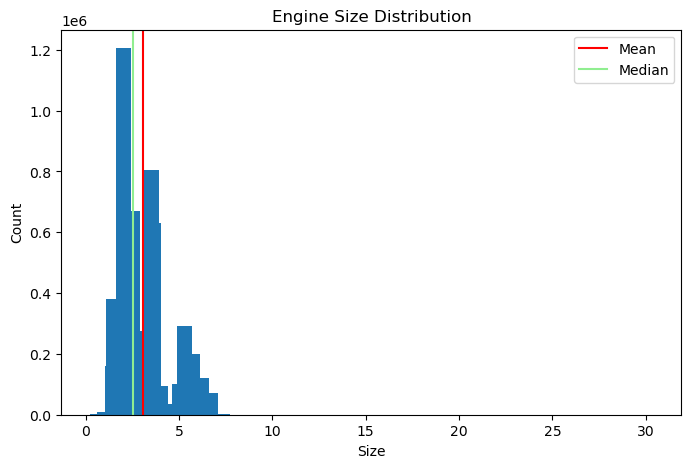

In [130]:
engine_size_series = df["engine_size"]
engine_size_val_count = engine_size_series.value_counts()

# Set up plt
plt.figure(figsize=(8,5))
# Plot
plt.bar(engine_size_val_count.index, engine_size_val_count.values)
# Plot vertical line for mean and median
plt.axvline(mean,color = "red",label = "Mean")
plt.axvline(med,color = "lightgreen",label = "Median")
# Plot Title & Axes
plt.title("Engine Size Distribution")
plt.xlabel("Size")
plt.ylabel("Count")
# Show Plot
plt.legend()
plt.show()

- It seems that there some outlier on the right. Lets plot a box plot.

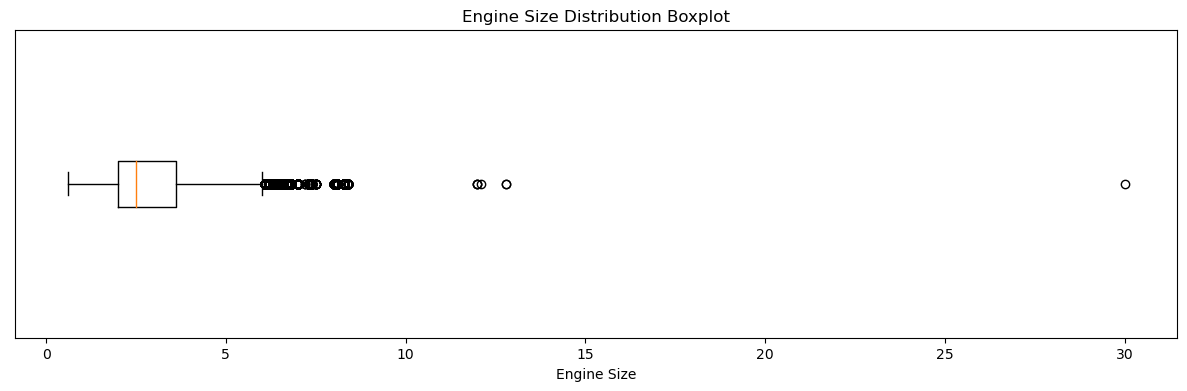

In [131]:
# Set up plot
plt.figure(figsize=(15,4))
# Plot
box = plt.boxplot(df["engine_size"].dropna(),vert=False)
# Plot title & axes
plt.title("Engine Size Distribution Boxplot")
plt.xlabel("Engine Size")
plt.yticks([]) # Remove y axis tick
# Show Plot
plt.show()

- As we can see from the distribution and boxplot above, the data is highly right skewed.
- Perhaps we can fill the null value with either the mean or median.
- To stay consistency with the column above (i.e. `miles`), we stick with the method of filling na with median.

#### Fill Null Value

In [132]:
# Fill the null value with median
df["engine_size"].fillna(med,inplace=True)

##### Double check null value count

In [133]:
# Check any null value in `miles` column
print_null_count(df,["engine_size"])

=== Null Count ===
Column `engine_size`: 0


---

### Column: `engine_block` <a class="anchor" id="col-engine-block"></a>

#### Null Value Check

In [134]:
# How many null value in this column
print_null_count(df,["engine_block"])

=== Null Count ===
Column `engine_block`: 146885


In [135]:
# Precentage of null value in this column
print_null_pct(df,["engine_block"])

=== Null Count Precentage ===
Column engine_block: 2.1582%


#### Question: How to deal with the null values?
- As the null percentage of the column `engine_block` reaches 2.15%, we need to handle them properly.

In [136]:
# Check value_count in the column
target_col_val_count = df["engine_block"].value_counts()
target_col_val_count

I    3424870
V    3042045
H     191996
Name: engine_block, dtype: int64

In [137]:
print(f"There are {len(target_col_val_count)} distinct value in `engine_block` column.")

There are 3 distinct value in `engine_block` column.


#### Question: Is it possible to guess the `engine_block` type by the year of the model, the model and the maker of the car and the engine size? 

- Similar to `drivetrain` and `transmissionn`, we can apply the same method to `engine_block` type.
- The possible guess is that the same car model built by the same maker in the same year should have the same `engine_block` type.
- For some car models, they may have different `engine_block`. If that is the case, we can guess their `engine_block` based on the occurrence grouped by the `year`, `make`, `model` and `engine_size`, and then calculate their corresponding probabilities.
- Lastly, we randomly selected the `engine_block` type based on their probabilities.

In [138]:
# Create a temporary dataframe for this part
temp_df = df[["year","make","model","engine_size","engine_block"]]
temp_df.head()

,year,make,model,engine_size,engine_block
0,2017.0,Acura,NSX,3.5,V
1,2017.0,Acura,NSX,3.5,V
2,2017.0,Acura,NSX,3.5,V
3,2020.0,Acura,NSX,3.5,V
4,2020.0,Acura,NSX,3.5,V


##### Group the `year`, `make`, `model` and `engine_size` as one column

In [139]:
# Create columns that aggregate the `year`, `make`, `model` and `engine_size`
# Note: "year" column is in float format. 
# `astype(int)` transform the year from float to int
# Then, `astype(str)` transform the year from int to str for concatenation 
temp_df["year-make-model-size"] = df["year"].astype(int).astype(str) + "-" + df["make"] + "-" + df["model"]+ "-" + df["engine_size"].astype(str)
temp_df.head()

/Users/anthonykwok/anaconda3/envs/bs-capstone/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,year,make,model,engine_size,engine_block,year-make-model-size
0,2017.0,Acura,NSX,3.5,V,2017-Acura-NSX-3.5
1,2017.0,Acura,NSX,3.5,V,2017-Acura-NSX-3.5
2,2017.0,Acura,NSX,3.5,V,2017-Acura-NSX-3.5
3,2020.0,Acura,NSX,3.5,V,2020-Acura-NSX-3.5
4,2020.0,Acura,NSX,3.5,V,2020-Acura-NSX-3.5


##### Count drivetrain occurrence

In [140]:
# Count how the occurrence of `engine_block` for each `year-make-model-size` combination
year_make_model_size_engine_block_count = \
    temp_df\
    .groupby(["year-make-model-size","engine_block"])["engine_block"]\
    .count()\
    .unstack()\
    .fillna(0)\
    .reset_index(drop = False)\
    .set_index(keys = ["year-make-model-size"])
year_make_model_size_engine_block_count.tail()

engine_block,H,I,V
year-make-model-size,,,
2022-MINI-Countryman-1.5,0.0,22.0,0.0
2022-MINI-Hardtop 4 Door-1.5,0.0,48.0,0.0
2022-MINI-Hardtop 4 Door-2.0,0.0,50.0,0.0
2022-Mitsubishi-Eclipse Cross-1.5,0.0,8.0,0.0
2022-Mitsubishi-Outlander-2.5,0.0,7.0,0.0


##### Convert into probability by normalization

In [141]:
# Get the normalized version for the probability
year_make_model_size_engine_block_prob = \
    year_make_model_size_engine_block_count.div(year_make_model_size_engine_block_count.sum(axis=1), axis=0)
year_make_model_size_engine_block_prob = year_make_model_size_engine_block_prob.T.to_dict()
year_make_model_size_engine_block_prob

{'1981-BMW-6-Series-3.2': {'H': 0.0, 'I': 0.0, 'V': 1.0},
 '1981-Cadillac-Eldorado-6.0': {'H': 0.0, 'I': 0.0, 'V': 1.0},
 '1981-Chevrolet-C/K 10-5.0': {'H': 0.0, 'I': 0.0, 'V': 1.0},
 '1981-Chevrolet-Camaro-5.0': {'H': 0.0, 'I': 0.0, 'V': 1.0},
 '1981-Chevrolet-Camaro-5.7': {'H': 0.0, 'I': 0.0, 'V': 1.0},
 '1981-Chevrolet-Corvette-5.7': {'H': 0.0, 'I': 0.0, 'V': 1.0},
 '1981-Ferrari-308-2.9': {'H': 0.0, 'I': 0.0, 'V': 1.0},
 '1981-Ferrari-Convertible-2.9': {'H': 0.0, 'I': 0.0, 'V': 1.0},
 '1981-Lincoln-Mark VI-5.0': {'H': 0.0, 'I': 0.0, 'V': 1.0},
 '1981-Mercedes-Benz-380-3.8': {'H': 0.0, 'I': 0.0, 'V': 1.0},
 '1981-Pontiac-Firebird-5.0': {'H': 0.0, 'I': 0.0, 'V': 1.0},
 '1981-Porsche-911-3.0': {'H': 1.0, 'I': 0.0, 'V': 0.0},
 '1981-Porsche-Coupe-3.0': {'H': 1.0, 'I': 0.0, 'V': 0.0},
 '1981-Rolls-Royce-Silver Spirit-6.8': {'H': 0.0, 'I': 0.0, 'V': 1.0},
 '1982-Cadillac-Deville-4.1': {'H': 0.0, 'I': 0.0, 'V': 1.0},
 '1982-Cadillac-Fleetwood-4.1': {'H': 0.0, 'I': 0.0, 'V': 1.0},
 '1982-C

##### Count drivetrain occurrence in original df

In [142]:
# Prepare the probability for random assignment if the combination is not found in both tables above.
engine_block_val_count = df["engine_block"].value_counts().to_frame()
engine_block_val_count

,engine_block
I,3424870
V,3042045
H,191996


##### Convert into probability by normalization

In [143]:
# Prepare the probability for general selection
engine_block_val_prob = engine_block_val_count.div(engine_block_val_count.sum(axis=0),axis=1)
engine_block_val_prob = engine_block_val_prob.to_dict()['engine_block']
engine_block_val_prob

{'I': 0.514328844461204, 'V': 0.45683821273478503, 'H': 0.028832942804011046}

##### Function to fill NA

In [144]:


def fill_na_by_year_make_model_size(df: pd.DataFrame,
                                    column_to_fill: str,
                                    year_make_model_size_prob: dict,
                                    random_prob: dict,
                                    inplace = True):
    """
    Description
    -----
    This function is designed for filling the null value based of the occurrence and probability of the combination of `year`, `make`, `model` and `engine_size`.
    If the key (`year`, `make`, `model`, `engine_size`) is not found in `year_make_model_size_prob` then 
    use the occurrence probability of the distinct value in the `column_to_fill` in `random_prob`.
    
    Then, select one of the dictinst values from the `column_to_fill` based on the probability retrieved above.
    
    Args
    -----
    df (pd.DataFrame): the original dataframe
    column_to_fill (str): our target column to fill the null value
    year_make_model_size_prob (dict): a dictionary with the key of each (`year`, `make`, `model`, `engine_size`) combination and 
                                      value of the probabilities of the values in the target column
    random_prob (dict):  a dictionary with the key of each value in the target column and 
                            value of the probabilities of each value
    inplace (boolean): whether to fill the null value in the original dataframe. Use `False` for deubgging purpose. Default: `True`. 
    
    Returns
    -----
    None
        
    
    """
    
    # Validation
    assert column_to_fill in df.columns, "'column_to_fill' must be one of the column names in 'df'."
        
    # Get total null count
    total_null_count = df[column_to_fill].isna().sum()
    
    # Variable for counting how many rows filled
    i_count = 0
    
    # Implement cache to speed up search
    year_make_model_size_cache = {}
    general_cache=[]
    general_cache_filled = False
    
    # New list to store the new data
    index_list = []
    target_col_list = []
    
    # Iterate through all rows with null value in `column_to_fill`
    for ind, row in df[df[column_to_fill].isna()].sort_values(by=["year","make","model","engine_size"]).iterrows():
        
        # Construct the key and sub_key for search
        key = str(int(row["year"]))+"-"+row["make"]+"-"+row["model"] + "-" + str(row["engine_size"])
        
        # If year-make-model key is found in cache
        if key in year_make_model_size_cache:
            
            # Retrieve the choice
            choice = year_make_model_size_cache[key][0]
            # Retrieve the probability
            prob = year_make_model_size_cache[key][1]
            # Selected one of the available option based on the probability
            selected = np.random.choice(choice,
                                        p=prob)
            
        # If the key is not in cache, search the index from original dict  
        elif key in year_make_model_size_prob:

            # Retrieve the choice
            choice = list(year_make_model_size_prob[key].keys())
            # Retrieve the probability
            prob = list(year_make_model_size_prob[key].values())
            # Selected one of the available option based on the probability
            selected = np.random.choice(choice,
                                        p=prob)
            # Save it in cache
            year_make_model_size_cache[key] = [choice,prob]

        # If year-make-model key is NOT found, Go to sub_key
        else:
            
            # If general selection cache is found
            if general_cache_filled:

                # Retrieve the choice
                choice = general_cache[0]
                # Retrieve the probability
                prob = general_cache[1]
                # Selected one of the available option based on the probability
                selected = np.random.choice(choice,
                                            p=prob)

            else:
                # Retrieve the choice
                choice = list(random_prob.keys())
                # Retrieve the probability
                prob = list(random_prob.values())
                # Selected one of the available option based on the probability
                selected = np.random.choice(choice,
                                            p=prob)

                # Save it in general_cache
                general_cache = [choice, prob]
                general_cache_filled = True
                    
        
        
        # Store the index and data in a list first
        index_list.append(ind)
        target_col_list.append(selected)
    
        
        i_count += 1
        if i_count % 10000 == 0:
            print(f"Filled rows: {i_count} / {total_null_count}")
          
    # Convert the data into df and store it back to original df
    new_df = pd.DataFrame({column_to_fill:target_col_list},index=index_list)
    if inplace:
        df.loc[index_list,column_to_fill] = new_df.loc[index_list,column_to_fill]
    else:
        print(new_df.tail())
    print(f"Filling completed!Filled rows: {i_count} / {total_null_count}")
    

#### Fill Null Value

In [145]:
# How many null value in this column before fill na
print_null_count(df,["engine_block"])


=== Null Count ===
Column `engine_block`: 146885


In [146]:
%%timeit -n 1 -r 1  # time the execution

# Fill the NA with the function above
fill_na_by_year_make_model_size(df,
                                "engine_block",
                                year_make_model_size_engine_block_prob,
                                engine_block_val_prob,
                                inplace=True)

Filled rows: 10000 / 146885
Filled rows: 20000 / 146885
Filled rows: 30000 / 146885
Filled rows: 40000 / 146885
Filled rows: 50000 / 146885
Filled rows: 60000 / 146885
Filled rows: 70000 / 146885
Filled rows: 80000 / 146885
Filled rows: 90000 / 146885
Filled rows: 100000 / 146885
Filled rows: 110000 / 146885
Filled rows: 120000 / 146885
Filled rows: 130000 / 146885
Filled rows: 140000 / 146885
Filling completed!Filled rows: 146885 / 146885
13.5 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


##### Double check null value count

In [147]:
# How many null value in this column after filling NA
print_null_count(df,["engine_block"])

=== Null Count ===
Column `engine_block`: 0


---

### Column: `street` / `city` / `state` / `zip` <a class="anchor" id="col-location"></a>

#### Null Value Check

In [148]:
# How many null value in this column
print_null_count(df,["street","city","state","zip"])

=== Null Count ===
Column `street`: 35245
Column `city`: 17945
Column `state`: 18015
Column `zip`: 18145


In [149]:
# Precentage of null value in this column
print_null_pct(df,["street","city","state","zip"])

=== Null Count Precentage ===
Column street: 0.5179%
Column city: 0.2637%
Column state: 0.2647%
Column zip: 0.2666%


#### Let's check how many rows with all 4 columns are null

In [150]:
all_null = df[(df["street"].isna())&(df["city"].isna())&(df["state"].isna())&(df["zip"].isna())]
all_null.shape

(17897, 18)

In [151]:
print(f"There are {all_null.shape[0]} rows with all 4 columns of null value.")
print(f"It is around {round(all_null.shape[0]/df.shape[0]*100,2)}% of records.")

There are 17897 rows with all 4 columns of null value.
It is around 0.26% of records.


As address / location is one of the major factors to determine the listing price, we need location information. If all 4 columns are null, then we cannot retrieve any informtion from it, which means we need to drop them away.

In [152]:
df.dropna(subset=["street","city","state","zip"],how="all",inplace = True)
df.head()

,vin,miles,year,make,model,trim,body_type,vehicle_type,drivetrain,transmission,fuel_type,engine_size,engine_block,street,city,state,zip,price_range
0,19UNC1B01HY800062,9966.0,2017.0,Acura,NSX,Base,Coupe,Car,4WD,Automatic,Electric / Premium Unleaded,3.5,V,475 Rue Victoria,Edmundston,NB,E3V 2K7,5
1,19UNC1B02HY800023,5988.0,2017.0,Acura,NSX,Base,Coupe,Car,4WD,Automatic,Electric / Premium Unleaded,3.5,V,2795 Route-du-prsident-kennedy,Notre-dame-des-pins,QC,G0M 1K0,5
2,19UNC1B02HY800071,24242.0,2017.0,Acura,NSX,Base,Coupe,Car,4WD,Automatic,Electric / Premium Unleaded,3.5,V,1388 Lougheed Highway,Coquitlam,BC,V3K 6S4,5
3,19UNC1B02LY800001,6637.0,2020.0,Acura,NSX,Base,Coupe,Car,4WD,Automatic,Electric / Premium Unleaded,3.5,V,1305 Parkway Suite 600,Pickering,ON,L1V 3P2,5
4,19UNC1B02LY800001,6637.0,2020.0,Acura,NSX,Base,Coupe,Car,4WD,Automatic,Electric / Premium Unleaded,3.5,V,575 Kingston Road,Pickering,ON,L1V 3N7,5


#### Check how many rows and columns left

In [153]:
print_dim(df)

There are 6787899 rows and 18 columns in this dataframe now.


#### Obtain information from `street`
- As street is not a good feature for modelling, we can extract the `city`, `state` and `zip` from the `street`.

In [154]:
# How many null value in this column
print_null_count(df,["street","city","state","zip"])

=== Null Count ===
Column `street`: 17348
Column `city`: 48
Column `state`: 118
Column `zip`: 248


In [155]:
city_df = df[~(df["street"].isna())&((df["city"].isna())|(df["state"].isna())|(df["zip"].isna()))]
city_df.head()

,vin,miles,year,make,model,trim,body_type,vehicle_type,drivetrain,transmission,fuel_type,engine_size,engine_block,street,city,state,zip,price_range
3350,YV4BC0PMXG1066761,60000.0,2016.0,Volvo,XC90,R-Design,SUV,Truck,4WD,Automatic,Electric / Premium Unleaded,2.0,I,540 Boulevard Gr�ber,None,QC,None,4
3506,19UUA66278A800666,165000.0,2008.0,Acura,TL,Not Provided,Sedan,Car,FWD,Automatic,Premium Unleaded,2.5,V,540 Boulevard Gr�ber,None,QC,None,1
3510,19UUA86519A801626,142772.0,2009.0,Acura,TL,Not Provided,Sedan,Car,FWD,Automatic,Premium Unleaded,2.5,I,2563 Eglinton Ave East,Scarborough,None,M1K 2R7,2
6378,1C6RR7TT4FS594270,145260.0,2015.0,RAM,Ram 1500 Pickup,Not Provided,Pickup,Truck,4WD,Automatic,Unleaded,2.5,V,540 Boulevard Gr�ber,None,QC,None,2
6642,1D4PU5GK8BW575912,132418.0,2011.0,Dodge,Nitro,Not Provided,Not Provided,Car,4WD,Automatic,Unleaded,2.5,I,261 Hespeler Rd Unit C,Cambridge,None,N1R 3H8,1


##### Replace unknown characters and add country for some addresses
- Note that one of the addressed includes french, which is mistakenly parse during the data loading stage.  
- We will convert it into proper text manually.
- Some addresses requires country for accurate geocoding

In [156]:
street_correction = {"540 Boulevard Gr�ber":'540 Boulevard Greber',
                     "2871 Ontario 7a":"2871 Ontario 7a, Canada",
                     "3026 Highway 16 East, Thornhill":"3026 BC-16, Thornhill",
                     "261 Hespeler Rd Unit C":"261 Hespeler Rd c"
                    }
df["street"].replace(street_correction, inplace=True)

In [157]:
city_df = df[~(df["street"].isna())&((df["city"].isna())|(df["state"].isna())|(df["zip"].isna()))]
city_df.head()

,vin,miles,year,make,model,trim,body_type,vehicle_type,drivetrain,transmission,fuel_type,engine_size,engine_block,street,city,state,zip,price_range
3350,YV4BC0PMXG1066761,60000.0,2016.0,Volvo,XC90,R-Design,SUV,Truck,4WD,Automatic,Electric / Premium Unleaded,2.0,I,540 Boulevard Greber,None,QC,None,4
3506,19UUA66278A800666,165000.0,2008.0,Acura,TL,Not Provided,Sedan,Car,FWD,Automatic,Premium Unleaded,2.5,V,540 Boulevard Greber,None,QC,None,1
3510,19UUA86519A801626,142772.0,2009.0,Acura,TL,Not Provided,Sedan,Car,FWD,Automatic,Premium Unleaded,2.5,I,2563 Eglinton Ave East,Scarborough,None,M1K 2R7,2
6378,1C6RR7TT4FS594270,145260.0,2015.0,RAM,Ram 1500 Pickup,Not Provided,Pickup,Truck,4WD,Automatic,Unleaded,2.5,V,540 Boulevard Greber,None,QC,None,2
6642,1D4PU5GK8BW575912,132418.0,2011.0,Dodge,Nitro,Not Provided,Not Provided,Car,4WD,Automatic,Unleaded,2.5,I,261 Hespeler Rd c,Cambridge,None,N1R 3H8,1


##### Obtain `city`, `state` and `zip` from `street`

In [158]:
# Get the unique address in the above df
address_to_be_retrieve = list(set(city_df['street']))
address_to_be_retrieve

['2563 Eglinton Ave East',
 '502 Chemin Vanier',
 '3026 BC-16, Thornhill',
 '540 Boulevard Greber',
 '5001 Steeles Ave West',
 '3877 Canada Way',
 '522 Boul Des Laurentides',
 '2512 Bristol Circle',
 '4800 Whitesburg Dr #30',
 '261 Hespeler Rd c',
 '2871 Ontario 7a, Canada']

In [159]:
address_dict = {}
completed = False
attempt = 0
while not completed:
    try:
        attempt += 1
        print(f"--- Attempt: {attempt} ---")
        for i, address in enumerate(address_to_be_retrieve):

            # Wait for 1 sec to avoid API banning / Connection Timeout
            if i % 3 == 0:
                time.sleep(0.5)


            # address is a String e.g. 'Berlin, Germany'
            # addressdetails=True does the magic and gives you also the details
            geolocator = Nominatim(user_agent="bs-capstone")
            location = geolocator.geocode(address, addressdetails=True)
            if location is not None:
                details = location.raw["address"]

                try:
                    city = details["city"]
                except:
                    city = details["county"]
                state = details["ISO3166-2-lvl4"].split("-")[1]
                zip_code = details["postcode"]

                address_dict[address] = {"city":city,"state":state,"zip":zip_code}
            else:
                print(f"Adderss Not Found: {address}")

        completed = True
        print("Completed...")
    # If there is any error or crashing, reset the dict and retry until completed.
    except:
        address_dict = {}
        completed = False

--- Attempt: 1 ---
--- Attempt: 2 ---
Completed...


#### Fill Null Value in columns `city`, `state` and `zip`

In [160]:
# Set up for fill na steps
cols = ["city","state","zip"]
new_df = pd.DataFrame(columns=cols)
index_list = []
data_dict = {}
for col in cols:
    data_dict[col] = []
    
# Load the new data from the address dictionary
for ind, row in df[~(df["street"].isna())&((df["city"].isna())|(df["state"].isna())|(df["zip"].isna()))].iterrows():

    index_list.append(ind)
    loc = row["street"]
    for col in cols:
        data_dict[col].append(address_dict[loc][col]) 
new_df = pd.DataFrame(data_dict,index=index_list)
df.loc[index_list,cols] = new_df.loc[index_list,cols]


##### Double check null value count

In [161]:
# How many null value in this column
print_null_count(df,["street","city","state","zip"])

=== Null Count ===
Column `street`: 17348
Column `city`: 0
Column `state`: 10
Column `zip`: 58


#### Null Value Check in `state` and `zip`

In [162]:
df[df["state"].isna()]

,vin,miles,year,make,model,trim,body_type,vehicle_type,drivetrain,transmission,fuel_type,engine_size,engine_block,street,city,state,zip,price_range
455905,5N1AR2MN8GC673487,91502.0,2016.0,Nissan,Pathfinder,Not Provided,SUV,Truck,4WD,Automatic,Unleaded,2.5,I,None,Bundamba,None,None,2
456249,SJNFDAJ11A1342807,24411.0,2015.0,Nissan,Not Provided,WAGON,Not Provided,Car,FWD,Automatic,Unleaded,2.5,V,None,Bundamba,None,None,2
456628,WAUZZZ8K9DA053414,189512.0,2012.0,Audi,A4,SEDAN,Not Provided,Car,FWD,Automatic,Premium Unleaded,2.5,I,None,Bowen Hills,None,None,2
457579,WAUZZZ8U0CR035658,159181.0,2012.0,Audi,Q3,QUATTRO,Wagon,Car,4WD,Automatic,Premium Unleaded,2.5,I,None,Bowen Hills,None,None,2
2225517,WAUZZZ8U8CR027257,112015.0,2012.0,Audi,Q3,QUATTRO,Wagon,Car,4WD,Automatic,Premium Unleaded,2.5,I,None,Bowen Hills,None,None,2
2231810,WDC1668242A525419,129092.0,2014.0,Mercedes-Benz,GL-Class,WAGON,Not Provided,Car,4WD,Automatic,Premium Unleaded,2.5,I,None,Bowen Hills,None,None,4
2231845,ZPBEA1ZL6MLA12057,2413.0,2020.0,Lamborghini,Urus,WAGON,Not Provided,Car,4WD,Automatic,Premium Unleaded,2.5,V,None,Bowen Hills,None,None,5
4005332,ZHWET5ZF9LLA15112,6912.0,2020.0,Lamborghini,Convertible,Spyder,Not Provided,Car,RWD,Automatic,Electric / Unleaded,2.5,I,None,Bowen Hills,None,None,5
5782249,SALWA2AK3KA822901,8919.0,2018.0,Land Rover,Range Rover Sport,WAGON,Not Provided,Car,4WD,Automatic,Premium Unleaded,2.5,V,None,Bowen Hills,None,None,5
5783299,WAUZZZ8P09A051439,138888.0,2009.0,Audi,A3,HATCHBACK,Not Provided,Car,FWD,Automatic,Premium Unleaded,2.5,I,None,Bowen Hills,None,None,1


For these records with `city` available only, it is impossible to retireve other columns information. So we will drop it.

In [163]:
df.dropna(subset=["state"],inplace = True)

##### Double check null value count

In [164]:
# How many null value in these columns
print_null_count(df,["street","city","state","zip"])

=== Null Count ===
Column `street`: 17338
Column `city`: 0
Column `state`: 0
Column `zip`: 48


In [165]:
df[df["zip"].isna()]

,vin,miles,year,make,model,trim,body_type,vehicle_type,drivetrain,transmission,fuel_type,engine_size,engine_block,street,city,state,zip,price_range
750045,KMHD84LF3JU626116,36820.0,2018.0,Hyundai,Elantra,Limited,Sedan,Car,FWD,Automatic,Unleaded,2.0,I,None,Ajax,ON,None,1
802377,JN1EV7AR4JM438272,17777.0,2018.0,INFINITI,Q50,Sport,Sedan,Car,4WD,Automatic,Premium Unleaded,3.0,V,None,Ajax,ON,None,3
916247,3VWG57AU2KM025845,46139.0,2019.0,Volkswagen,Golf,TSI S,Hatchback,Car,FWD,Automatic,Unleaded,1.4,I,None,Ajax,ON,None,2
922453,3VWG57AU5KM024401,33912.0,2019.0,Volkswagen,Golf,TSI S,Hatchback,Car,FWD,Automatic,Unleaded,1.4,I,None,Ajax,ON,None,2
1417384,5N1AT2MT9LC715255,9.0,2020.0,Nissan,Rogue,S,SUV,Truck,FWD,Automatic,Unleaded,2.5,I,None,Ajax,ON,None,2
1419075,5N1AT2MT4LC728284,21.0,2020.0,Nissan,Rogue,S,SUV,Truck,FWD,Automatic,Unleaded,2.5,I,None,Ajax,ON,None,2
1428846,5N1AT2MVXLC746015,4580.0,2020.0,Nissan,Rogue,SV,SUV,Truck,4WD,Automatic,Unleaded,2.5,I,None,Ajax,ON,None,2
1430134,5N1AT2MT5LC727807,9332.0,2020.0,Nissan,Rogue,S,SUV,Truck,FWD,Automatic,Unleaded,2.5,I,None,Ajax,ON,None,2
1436044,5N1AT2MV8KC708152,30869.0,2019.0,Nissan,Rogue,SV,Crossover,Truck,4WD,Automatic,Unleaded,2.5,I,None,Ajax,ON,None,2
2245769,1N4AZ1CP5JC303452,53190.0,2018.0,Nissan,LEAF,SL,Hatchback,Car,FWD,Automatic,Electric,2.5,V,None,Ajax,ON,None,2


#### Fill Null Value in columns `zip`

- For all the remaining row with null value in `zip`, they are all from `Ajax, ON`. So we will manually label the zip code as "L0H", which is the Postal Code for Ajax in Ontario.

In [166]:
df.loc[df["zip"].isna(),"zip"] = "L0H"

##### Double check null value count

In [167]:
# How many null value in these columns
print_null_count(df,["street","city","state","zip"])

=== Null Count ===
Column `street`: 17338
Column `city`: 0
Column `state`: 0
Column `zip`: 0


- Now, all `city`, `state` and `zip` columns are with no null value, we can drop the `street` column now.

In [168]:
df.drop(columns=["street"],inplace=True)

In [169]:
# Have a look on the remaining df
df.head()

,vin,miles,year,make,model,trim,body_type,vehicle_type,drivetrain,transmission,fuel_type,engine_size,engine_block,city,state,zip,price_range
0,19UNC1B01HY800062,9966.0,2017.0,Acura,NSX,Base,Coupe,Car,4WD,Automatic,Electric / Premium Unleaded,3.5,V,Edmundston,NB,E3V 2K7,5
1,19UNC1B02HY800023,5988.0,2017.0,Acura,NSX,Base,Coupe,Car,4WD,Automatic,Electric / Premium Unleaded,3.5,V,Notre-dame-des-pins,QC,G0M 1K0,5
2,19UNC1B02HY800071,24242.0,2017.0,Acura,NSX,Base,Coupe,Car,4WD,Automatic,Electric / Premium Unleaded,3.5,V,Coquitlam,BC,V3K 6S4,5
3,19UNC1B02LY800001,6637.0,2020.0,Acura,NSX,Base,Coupe,Car,4WD,Automatic,Electric / Premium Unleaded,3.5,V,Pickering,ON,L1V 3P2,5
4,19UNC1B02LY800001,6637.0,2020.0,Acura,NSX,Base,Coupe,Car,4WD,Automatic,Electric / Premium Unleaded,3.5,V,Pickering,ON,L1V 3N7,5


### Save the cleaned data in parquet format  <a class="anchor" id="save-cleaned"></a>

In [170]:
# Remove duplicates
df.drop_duplicates(inplace=True)

# Save as parquet
df.to_parquet(path="data/cleaned-data.parquet",
              index = False)

[Back-to-top](#toc)

---

## Data Preprocessing <a class="anchor" id="preprocess"></a>

Table of Contents for this part: 
- [Reload Cleaned Data](#load-clean)
- [Column Flattening](#flatten)
- [Possible Dummy Encoding Opportunity](#dummy)

For data preprocessing, there are several things to be completed.
1. `fuel_type` column flattening (as it has multiple values in each cell)
2. Categorical Data Enconding
3. Same vehicle history 

In this section, we will go through #1 only and left the #2 and #3 in the feature engineering part.

### Load Cleaned Dataset <a class="anchor" id="load-clean"></a>

In [171]:
# Define dtype for cleaned dataset
CLEAN_COL_DTYPE = {
    "vin":str,
    "miles":float,
    "year":int,
    "make":str,
    "model":str,
    "trim":str,
    "body_type":str,
    "vehicle_type":str,
    "drivetrain":str,
    "transmission":str,
    "fuel_type":str,
    "engine_size":float,
    "engine_block":str,
    "city":str,
    "state":str,
    "zip":str,
    "price_range":int
}

In [172]:
# First, we read the cleaned dataset
df = pd.read_parquet(path = "data/cleaned-data.parquet",
                     columns = CLEAN_COL_DTYPE)
df.reset_index(drop = True, inplace=True)

#### Sanity Check after Loading Data

In [173]:
df.isna().sum()

vin             0
miles           0
year            0
make            0
model           0
trim            0
body_type       0
vehicle_type    0
drivetrain      0
transmission    0
fuel_type       0
engine_size     0
engine_block    0
city            0
state           0
zip             0
price_range     0
dtype: int64

In [174]:
df.head()

,vin,miles,year,make,model,trim,body_type,vehicle_type,drivetrain,transmission,fuel_type,engine_size,engine_block,city,state,zip,price_range
0,19UNC1B01HY800062,9966.0,2017.0,Acura,NSX,Base,Coupe,Car,4WD,Automatic,Electric / Premium Unleaded,3.5,V,Edmundston,NB,E3V 2K7,5
1,19UNC1B02HY800023,5988.0,2017.0,Acura,NSX,Base,Coupe,Car,4WD,Automatic,Electric / Premium Unleaded,3.5,V,Notre-dame-des-pins,QC,G0M 1K0,5
2,19UNC1B02HY800071,24242.0,2017.0,Acura,NSX,Base,Coupe,Car,4WD,Automatic,Electric / Premium Unleaded,3.5,V,Coquitlam,BC,V3K 6S4,5
3,19UNC1B02LY800001,6637.0,2020.0,Acura,NSX,Base,Coupe,Car,4WD,Automatic,Electric / Premium Unleaded,3.5,V,Pickering,ON,L1V 3P2,5
4,19UNC1B02LY800001,6637.0,2020.0,Acura,NSX,Base,Coupe,Car,4WD,Automatic,Electric / Premium Unleaded,3.5,V,Pickering,ON,L1V 3N7,5


In [175]:
print_dim(df)

There are 4468296 rows and 17 columns in this dataframe now.


### Column `fuel_type` Flattening <a class="anchor" id="flatten"></a>

#### Multiple values in One Column
- It seems that there are several common values in the column `fuel_type` in one cell.
- For example: \['Electric', 'Premium Unleaded'\] in one cell etc.
- Let's decode each of them into a list to get the distinct fuel types
- Example:
|`fuel_type`|
|:---:|
|Electric / Premium Unleaded|
- Decoded: 
|`Electric`|`Diesel`|`Premium Unleaded`|`Hydrogen`|
|:---:|:---:|:---:|:---:|
|1|0|1|0|

In [176]:
def decode_fuel_type(s:str)-> list:
    """
    Description
    -----
    As there are multiple values in one cell in the columns `fuel_type`. We need to decode them into different columns as above.
    This function is specific for the `fuel_type` column to decode the string into a list of supported fuel types.
    
    Args
    -----
    s (str): the string in the column `fuel_type`
    
    Returns
    -----
    s5 (list): decoded list of fuel types
    
    Example:
    -----
    decode_fuel_type('Diesel; E85 / Unleaded') =>
        |
        | ['Diesel','E85','Unleaded']
        |
        
    decode_fuel_type('Compressed Natural Gas / Lpg') =>
        |
        | ['CompressedNaturalGas','Lpg']
        |
        
    decode_fuel_type('Electric / Premium Unleaded; Premium Unleaded') =>
        |
        | ['Electric','PremiumUnleaded']
        |
        
    
    """
    # Remove empty space
    s1 = s.replace(" ","")
    # Split by ';'
    s2 = s1.split(";")
    # The, split by ';'
    s3 = list(map(lambda x:x.split("/"),s2))
    # Flatten the list into 1-D list
    s4 = flatten_list(s3)
    # Drop duplicates
    s5 = list(set(s4))
    
    return s5

In [177]:
# List out all unique value in column `fuel_type`
fuel_type_list = list(set(df["fuel_type"]))
fuel_type_list

['Diesel / Premium Unleaded',
 'Electric / Unleaded',
 'Unleaded',
 'Diesel; Unleaded',
 'Diesel',
 'Premium Unleaded',
 'Premium Unleaded / E85',
 'E85 / Premium Unleaded',
 'E85 / Unleaded; Premium Unleaded',
 'Unleaded / Premium Unleaded',
 'Hydrogen',
 'Electric / Premium Unleaded',
 'Compressed Natural Gas',
 'E85 / Unleaded; Unleaded / Unleaded',
 'Premium Unleaded; Unleaded',
 'Unleaded; Unleaded / E85',
 'Compressed Natural Gas / Unleaded',
 'Unleaded / Electric',
 'Diesel; E85 / Unleaded',
 'E85 / Unleaded; Unleaded',
 'Premium Unleaded; Premium Unleaded / E85',
 'Premium Unleaded / Unleaded',
 'E85; E85 / Unleaded',
 'E85 / Unleaded; Unleaded / E85',
 'Electric / Hydrogen',
 'Unleaded / Unleaded',
 'Electric / Premium Unleaded; Premium Unleaded',
 'E85',
 'E85 / Unleaded',
 'Compressed Natural Gas; Unleaded',
 'Biodiesel',
 'Compressed Natural Gas / Lpg',
 'M85 / Unleaded',
 'Electric / E85',
 'Unleaded / E85',
 'E85 / Premium Unleaded; E85 / Unleaded',
 'Electric / Premium U

In [178]:
# Flatten the unique value in column `fuel_type`
decode_list = list(map(decode_fuel_type,fuel_type_list))
decode_list[:20]

[['Diesel', 'PremiumUnleaded'],
 ['Unleaded', 'Electric'],
 ['Unleaded'],
 ['Unleaded', 'Diesel'],
 ['Diesel'],
 ['PremiumUnleaded'],
 ['E85', 'PremiumUnleaded'],
 ['E85', 'PremiumUnleaded'],
 ['E85', 'Unleaded', 'PremiumUnleaded'],
 ['Unleaded', 'PremiumUnleaded'],
 ['Hydrogen'],
 ['Electric', 'PremiumUnleaded'],
 ['CompressedNaturalGas'],
 ['E85', 'Unleaded'],
 ['Unleaded', 'PremiumUnleaded'],
 ['Unleaded', 'E85'],
 ['Unleaded', 'CompressedNaturalGas'],
 ['Unleaded', 'Electric'],
 ['E85', 'Diesel', 'Unleaded'],
 ['E85', 'Unleaded']]

#### Distinct Value in Column `fuel_type`

In [179]:
decode_flat_list = flatten_list(decode_list)
decode_flat_list = list(set(decode_flat_list))
decode_flat_list

['Unleaded',
 'M85',
 'Diesel',
 'Biodiesel',
 'PremiumUnleaded',
 'Hydrogen',
 'E85',
 'CompressedNaturalGas',
 'Electric',
 'Lpg']

In [180]:
print(f"There are {len(decode_flat_list)} types of fuels in column `fuel_type`.")

There are 10 types of fuels in column `fuel_type`.


#### Record Occurrence for Encoding

In [181]:
df.reset_index(drop = True,inplace = True)
df.head()

,vin,miles,year,make,model,trim,body_type,vehicle_type,drivetrain,transmission,fuel_type,engine_size,engine_block,city,state,zip,price_range
0,19UNC1B01HY800062,9966.0,2017.0,Acura,NSX,Base,Coupe,Car,4WD,Automatic,Electric / Premium Unleaded,3.5,V,Edmundston,NB,E3V 2K7,5
1,19UNC1B02HY800023,5988.0,2017.0,Acura,NSX,Base,Coupe,Car,4WD,Automatic,Electric / Premium Unleaded,3.5,V,Notre-dame-des-pins,QC,G0M 1K0,5
2,19UNC1B02HY800071,24242.0,2017.0,Acura,NSX,Base,Coupe,Car,4WD,Automatic,Electric / Premium Unleaded,3.5,V,Coquitlam,BC,V3K 6S4,5
3,19UNC1B02LY800001,6637.0,2020.0,Acura,NSX,Base,Coupe,Car,4WD,Automatic,Electric / Premium Unleaded,3.5,V,Pickering,ON,L1V 3P2,5
4,19UNC1B02LY800001,6637.0,2020.0,Acura,NSX,Base,Coupe,Car,4WD,Automatic,Electric / Premium Unleaded,3.5,V,Pickering,ON,L1V 3N7,5


In [182]:
# Set up variable for iteration
index_list = []
fuel_dict = {}
for fuel in decode_flat_list:
    fuel_dict[f"fuel_{fuel}"] = []   
df_len = round(df.shape[0] / 1000000,2)

# Record the occurrence
for ind, row in df.iterrows():
    
    # Show status
    if (ind+1) % 100000 == 0:
        print(f"Decoded rows: {round((ind+1)/1000000,1)}0M / {df_len}M rows")
        
    # Mark the index
    index_list.append(ind)
    
    # Decode the fuel_type
    decoded_fuel_set = set(decode_fuel_type(row["fuel_type"]))

    for fuel in decode_flat_list:
        if set([fuel]).issubset(decoded_fuel_set):
            fuel_dict[f"fuel_{fuel}"].append(1)
        else:
            fuel_dict[f"fuel_{fuel}"].append(0)
            
fuel_decoded_df = pd.DataFrame(fuel_dict,index = index_list)
print(f"Decoding Completed...")

Decoded rows: 0.10M / 4.47M rows
Decoded rows: 0.20M / 4.47M rows
Decoded rows: 0.30M / 4.47M rows
Decoded rows: 0.40M / 4.47M rows
Decoded rows: 0.50M / 4.47M rows
Decoded rows: 0.60M / 4.47M rows
Decoded rows: 0.70M / 4.47M rows
Decoded rows: 0.80M / 4.47M rows
Decoded rows: 0.90M / 4.47M rows
Decoded rows: 1.00M / 4.47M rows
Decoded rows: 1.10M / 4.47M rows
Decoded rows: 1.20M / 4.47M rows
Decoded rows: 1.30M / 4.47M rows
Decoded rows: 1.40M / 4.47M rows
Decoded rows: 1.50M / 4.47M rows
Decoded rows: 1.60M / 4.47M rows
Decoded rows: 1.70M / 4.47M rows
Decoded rows: 1.80M / 4.47M rows
Decoded rows: 1.90M / 4.47M rows
Decoded rows: 2.00M / 4.47M rows
Decoded rows: 2.10M / 4.47M rows
Decoded rows: 2.20M / 4.47M rows
Decoded rows: 2.30M / 4.47M rows
Decoded rows: 2.40M / 4.47M rows
Decoded rows: 2.50M / 4.47M rows
Decoded rows: 2.60M / 4.47M rows
Decoded rows: 2.70M / 4.47M rows
Decoded rows: 2.80M / 4.47M rows
Decoded rows: 2.90M / 4.47M rows
Decoded rows: 3.00M / 4.47M rows
Decoded ro

In [183]:
# Check the enconded dataframe
fuel_decoded_df.head()

,fuel_Unleaded,fuel_M85,fuel_Diesel,fuel_Biodiesel,fuel_PremiumUnleaded,fuel_Hydrogen,fuel_E85,fuel_CompressedNaturalGas,fuel_Electric,fuel_Lpg
0,0,0,0,0,1,0,0,0,1,0
1,0,0,0,0,1,0,0,0,1,0
2,0,0,0,0,1,0,0,0,1,0
3,0,0,0,0,1,0,0,0,1,0
4,0,0,0,0,1,0,0,0,1,0


#### Concatanate Encoded Dataframe

In [184]:
decoded_df = pd.concat([df,fuel_decoded_df],axis = 1)
decoded_df.head()

,vin,miles,year,make,model,trim,body_type,vehicle_type,drivetrain,transmission,...,fuel_Unleaded,fuel_M85,fuel_Diesel,fuel_Biodiesel,fuel_PremiumUnleaded,fuel_Hydrogen,fuel_E85,fuel_CompressedNaturalGas,fuel_Electric,fuel_Lpg
0,19UNC1B01HY800062,9966.0,2017.0,Acura,NSX,Base,Coupe,Car,4WD,Automatic,...,0,0,0,0,1,0,0,0,1,0
1,19UNC1B02HY800023,5988.0,2017.0,Acura,NSX,Base,Coupe,Car,4WD,Automatic,...,0,0,0,0,1,0,0,0,1,0
2,19UNC1B02HY800071,24242.0,2017.0,Acura,NSX,Base,Coupe,Car,4WD,Automatic,...,0,0,0,0,1,0,0,0,1,0
3,19UNC1B02LY800001,6637.0,2020.0,Acura,NSX,Base,Coupe,Car,4WD,Automatic,...,0,0,0,0,1,0,0,0,1,0
4,19UNC1B02LY800001,6637.0,2020.0,Acura,NSX,Base,Coupe,Car,4WD,Automatic,...,0,0,0,0,1,0,0,0,1,0


#### Drop Column `fuel_type`

In [185]:
decoded_df = drop_cols_if_exist(decoded_df,["fuel_type"])

Successfully dropped columns: {'fuel_type'}


#### Sanity Check

In [186]:
decoded_df.head()

,vin,miles,year,make,model,trim,body_type,vehicle_type,drivetrain,transmission,...,fuel_Unleaded,fuel_M85,fuel_Diesel,fuel_Biodiesel,fuel_PremiumUnleaded,fuel_Hydrogen,fuel_E85,fuel_CompressedNaturalGas,fuel_Electric,fuel_Lpg
0,19UNC1B01HY800062,9966.0,2017.0,Acura,NSX,Base,Coupe,Car,4WD,Automatic,...,0,0,0,0,1,0,0,0,1,0
1,19UNC1B02HY800023,5988.0,2017.0,Acura,NSX,Base,Coupe,Car,4WD,Automatic,...,0,0,0,0,1,0,0,0,1,0
2,19UNC1B02HY800071,24242.0,2017.0,Acura,NSX,Base,Coupe,Car,4WD,Automatic,...,0,0,0,0,1,0,0,0,1,0
3,19UNC1B02LY800001,6637.0,2020.0,Acura,NSX,Base,Coupe,Car,4WD,Automatic,...,0,0,0,0,1,0,0,0,1,0
4,19UNC1B02LY800001,6637.0,2020.0,Acura,NSX,Base,Coupe,Car,4WD,Automatic,...,0,0,0,0,1,0,0,0,1,0


In [187]:
print_dim(decoded_df)

There are 4468296 rows and 26 columns in this dataframe now.


---

### Categorical Columns Encoding <a class="anchor" id="dummy"></a>
- For categorical encoding such as `dummy encoding` / `one-hot encoding`, we will leave it in `feature engineering` part.
- Our potential encoding methods would be as follow:
    1. `Dummy Encoding` (keep all categories + remove one column for dummy variable trap)
    2. `Dummy Encoding` (with fixed number of category, i.e. top 10 most frequent categories)
    3. `Dummy Encoding` (with value counts percentage threshold, i.e. only keep categories with more than X% of total records)
    4. `Ordinal Encoding` (for category with ordinal meaning)
    5. `Count Encoding`
    6. `Target Encoding`  

[Back-to-top](#toc)

---

## Exploratory Data Analysis <a class="anchor" id="eda"></a>

Table of Contents for this part: 
- [Numerical and Categorical Columns](#num-cat-col)
- [Univariate Analysis for Numerical Data](#num-uni)
- [Univariate Analysis for Categorical Data](#cat-uni)
- [Bivariate Analysis for Numerical Data](#num-bi)
- [Bivariate Analysis for Categorical Data](#cat-bi)
- [Further EDA](#fur-eda)

### Numerical and Categorical Columns  <a class="anchor" id="num-cat-col"></a>

In [188]:
decoded_df.dtypes

vin                           object
miles                        float64
year                         float64
make                          object
model                         object
trim                          object
body_type                     object
vehicle_type                  object
drivetrain                    object
transmission                  object
engine_size                  float64
engine_block                  object
city                          object
state                         object
zip                           object
price_range                    int64
fuel_Unleaded                  int64
fuel_M85                       int64
fuel_Diesel                    int64
fuel_Biodiesel                 int64
fuel_PremiumUnleaded           int64
fuel_Hydrogen                  int64
fuel_E85                       int64
fuel_CompressedNaturalGas      int64
fuel_Electric                  int64
fuel_Lpg                       int64
dtype: object

- We have the following columns:
| # | Numerical Columns| Categorical Columns|
|:---:|:---|:---|
|1|`miles`|`make`|
|2|`year`|`model`|
|3|`engine_size`|`trim`|
|4|`fuel_Lpg`|`body_type`|
|5|`fuel_E85`|`vehicle_type`|
|6|`fuel_Diesel`|`drivetrain`|
|7|`fuel_PremiumUnleaded`|`transmission`|
|8|`fuel_CompressedNaturalGas`|`engine_block`|
|9|`fuel_Biodiesel`|`city`|
|10|`fuel_M85`|`state`|
|11|`fuel_Unleaded`|`zip`|
|12|`fuel_Electric`||
|13|`fuel_Hydrogen`||
 

### Univariate Analysis - Numerical  <a class="anchor" id="num-uni"></a>

#### Histogram for `miles`, `year` and `engine_size`

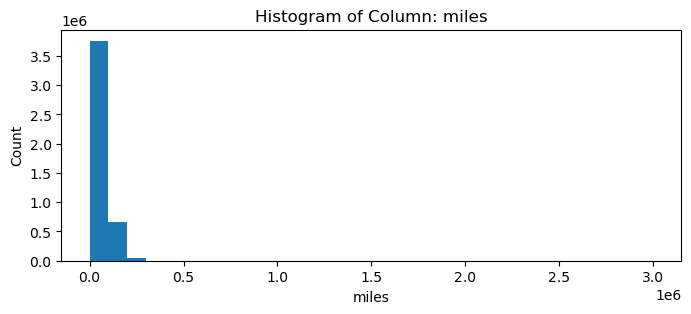

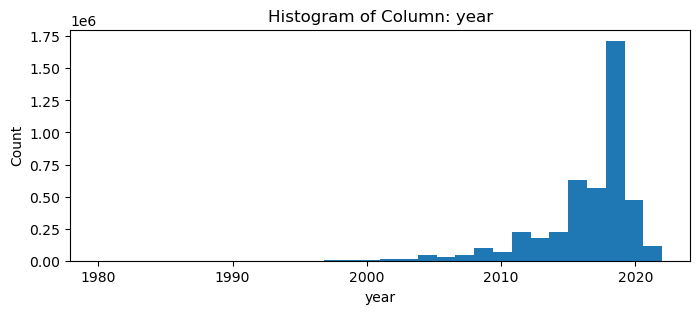

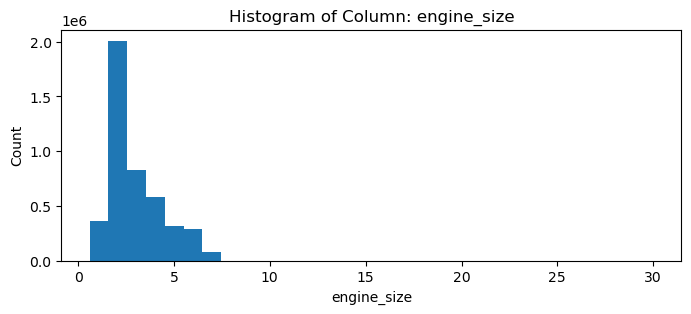

In [189]:
continuous_num_cols = ['miles', 'year', 'engine_size']

for num_col in continuous_num_cols:
    # Set up plot
    plt.figure(figsize=(8,3))

    # Plot
    plt.hist(decoded_df[num_col],bins = 30)
    
    # Title and Axis
    plt.title(f"Histogram of Column: {num_col}")
    plt.ylabel("Count")
    plt.xlabel(num_col)

    # Show plot
    plt.show()

Insight:
- For `miles` and `engine_size`, we can see that most of the data lie on the left. There may be some extreme large values on the right end.
- For `year`, as it is time-related, the used car listing count increased from time to time.
- For `year`, there is a huge drop after 2020. The possible reason could be the impact from COVID outbreak in 2020.

#### Replot for `miles` and `engine_size`
- Let's set the upper bound of `miles` plot to 250,000
- Let's set the upper bound of `engine_size` plot to 8

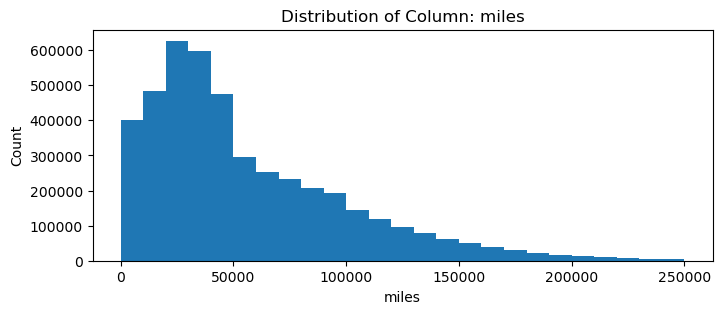

In [190]:
# Set up plot
plt.figure(figsize=(8,3))

# Plot Distribution
plt.hist(decoded_df[decoded_df["miles"]<=250000]["miles"],bins= 25)

# Title and Axis
plt.title(f"Distribution of Column: miles")
plt.ylabel("Count")
plt.xlabel("miles")

# Show plot
plt.show()

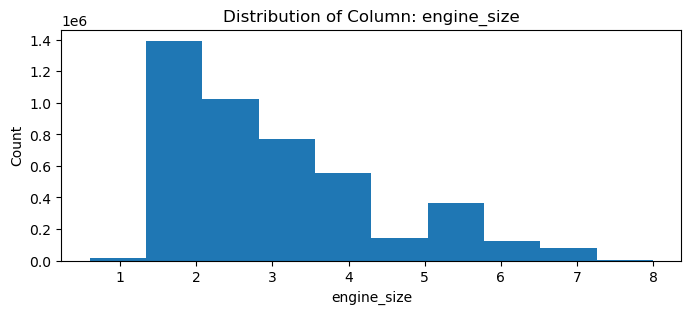

In [191]:
# Set up plot
plt.figure(figsize=(8,3))

# Plot Distribution
plt.hist(decoded_df[decoded_df["engine_size"]<=8]["engine_size"],bins= 10)

# Title and Axis
plt.title(f"Distribution of Column: engine_size")
plt.ylabel("Count")
plt.xlabel("engine_size")

# Show plot
plt.show()

Insight:
- Both `miles` and `engine_size` are right-skewed and tend to have a smaller value.

#### Bar Plot for `fuel_type`

In [192]:
fuel_tpye_col = ['fuel_CompressedNaturalGas', 'fuel_Biodiesel', 'fuel_E85',
       'fuel_Electric', 'fuel_Hydrogen', 'fuel_Lpg', 'fuel_PremiumUnleaded',
       'fuel_M85', 'fuel_Diesel', 'fuel_Unleaded']


In [193]:
fuel_col_count = decoded_df[fuel_tpye_col].sum(axis = 0).sort_values()
fuel_col_count

fuel_M85                           2
fuel_Lpg                           7
fuel_Hydrogen                    179
fuel_CompressedNaturalGas        299
fuel_Biodiesel                   542
fuel_Diesel                   110271
fuel_Electric                 119223
fuel_E85                      363216
fuel_PremiumUnleaded          983918
fuel_Unleaded                3358936
dtype: int64

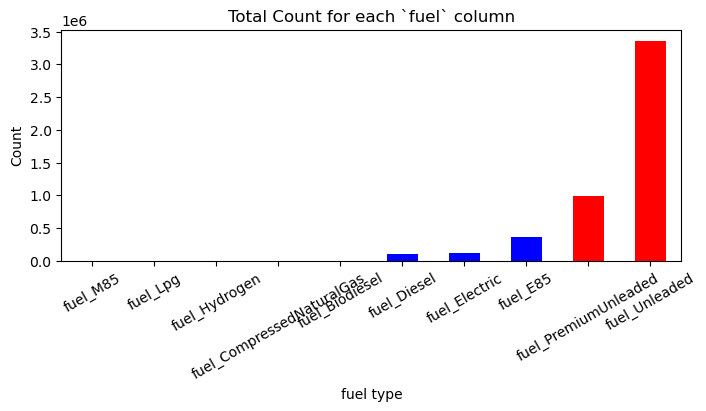

In [194]:
# Set up plot
plt.figure(figsize=(8,3))

# Plot
colors = ["blue" if i < len(fuel_col_count)-2 else "red" for i in range(len(fuel_col_count))]
fuel_col_count.plot(kind="bar",color = colors)

# Title and Axis
plt.title(f"Total Count for each `fuel` column")
plt.ylabel("Count")
plt.xlabel("fuel type")
plt.xticks(rotation = 30)

# Show plot
plt.show()

Note that:
- For one vehicle, it can be supported by different types of fuels, which means there could have more than one 1's in the same row in these columns.
- For the first five columns on the left, they are so few that not even shown in the bar plot. 
- For columns `M85` and `Lpg`, they have less than 10 occurrence. There will be many 0's in these columns, which may result in high correlation with each other. We may need to handle them properly before model fitting.
- The most popular fuel type are `Unleaded` and `PremiumUnleaded` (red bar).

---

### Univariate Analysis - Categorical  <a class="anchor" id="cat-uni"></a>

#### Columns with too many Distinct Values
- For those columns with too many distinct values

In [195]:
discrete_cols = ['make', 'model', 'trim', 'body_type',
                 'vehicle_type', 'drivetrain', 'transmission',
                 'engine_block', 'city', 'state', 'zip']
for dis_col in discrete_cols:
    distinct_val = set(decoded_df[dis_col])
    if len(distinct_val) > 50:
        print(f"Column: {dis_col} has {len(distinct_val)} distinct values")

Column: make has 63 distinct values
Column: model has 1252 distinct values
Column: trim has 2492 distinct values
Column: city has 6095 distinct values
Column: state has 68 distinct values
Column: zip has 13690 distinct values


- During the feature engineering stage, we will handle these categorical data with different encoding methods.
- In the following plots, we will only plot the top 100 values for these columns.

#### Barplot for Columns with over 50 distinct values


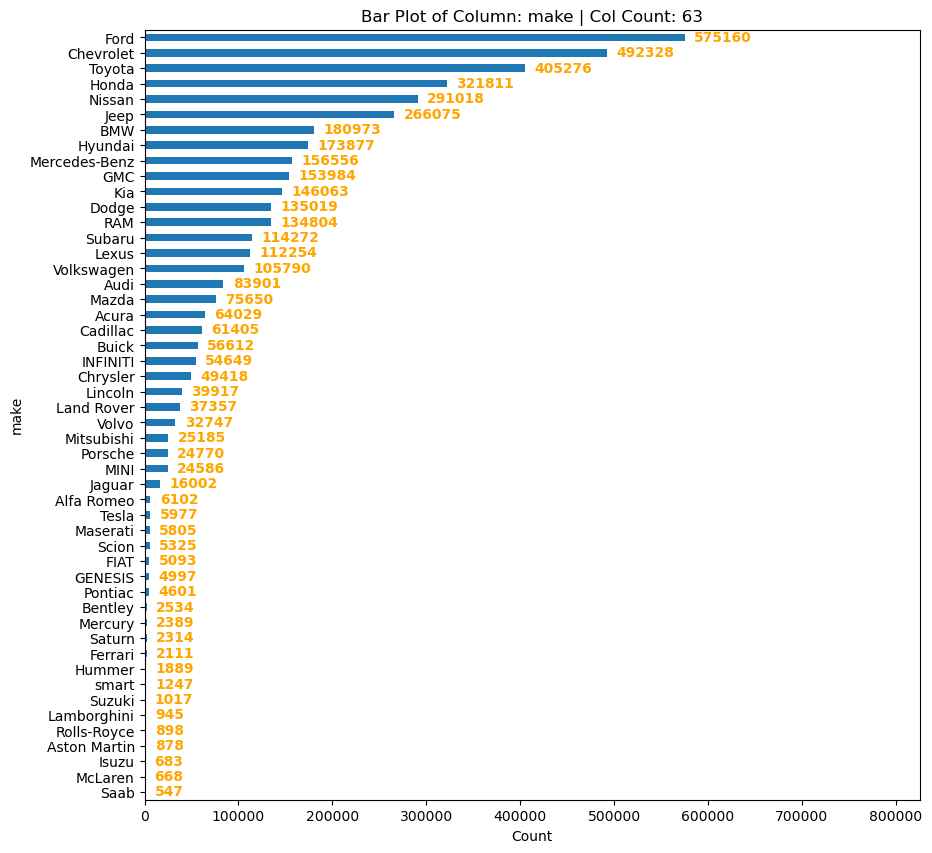

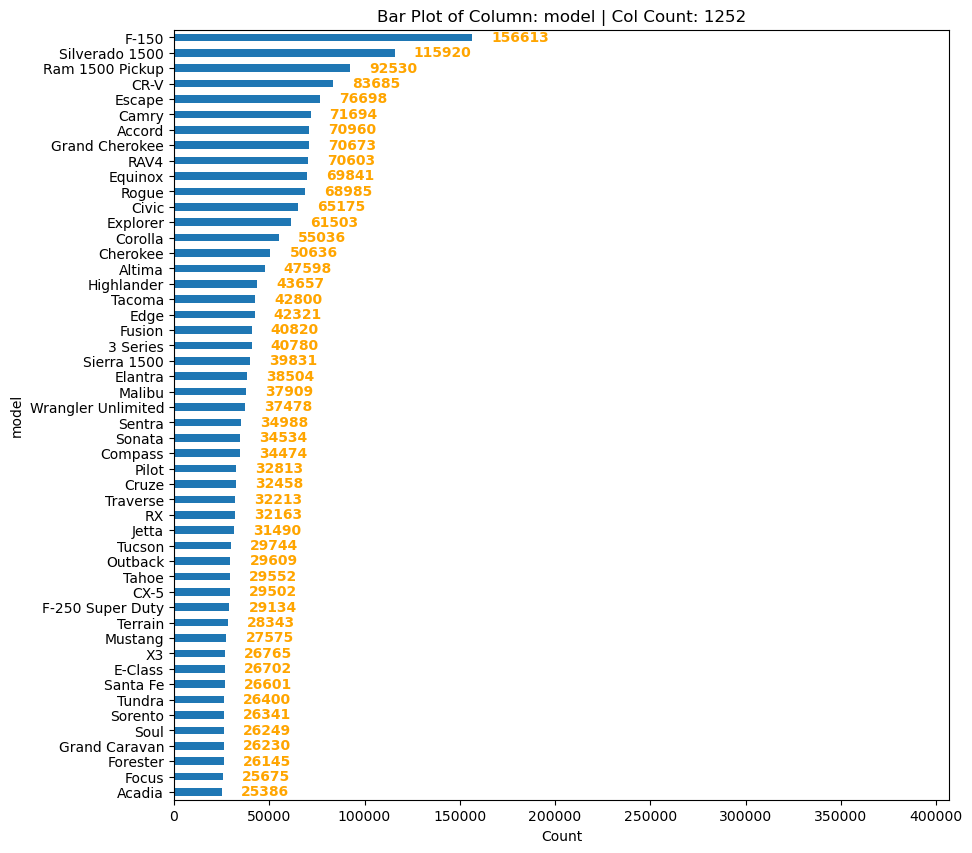

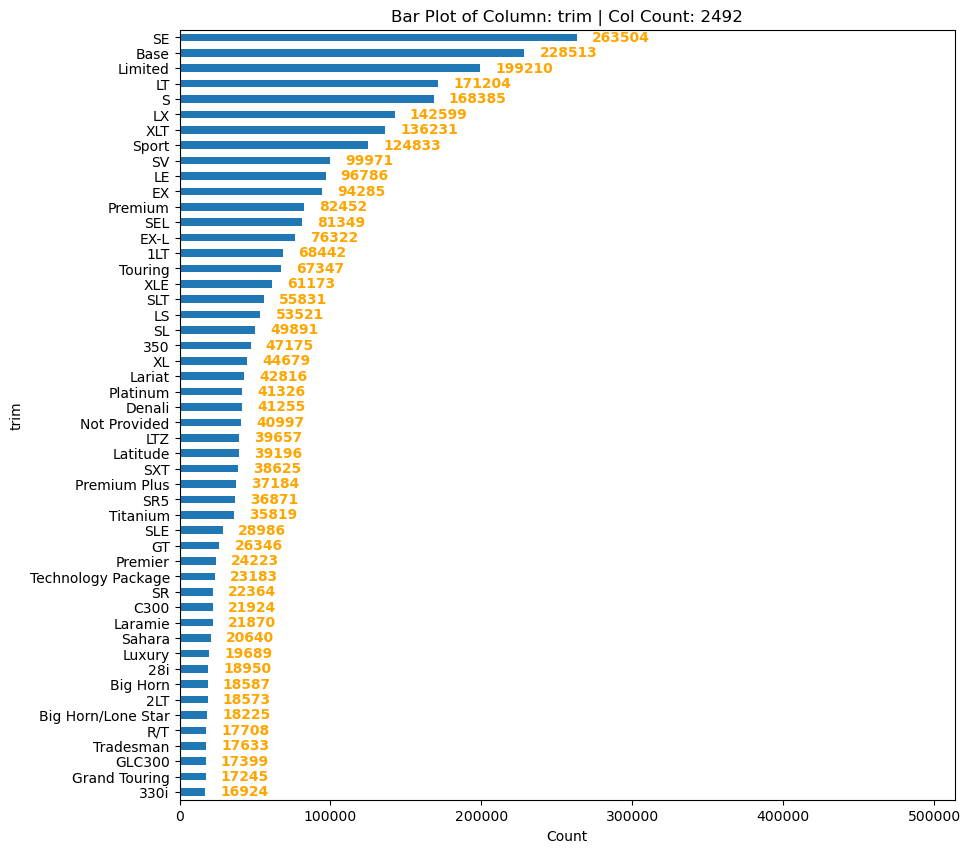

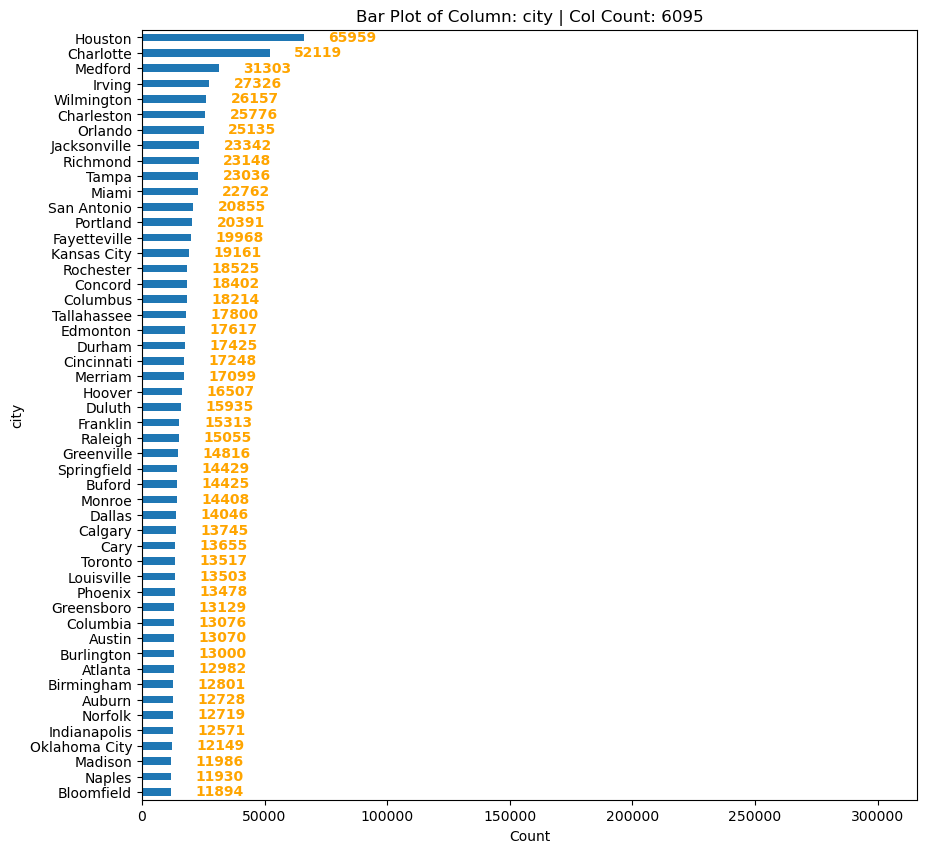

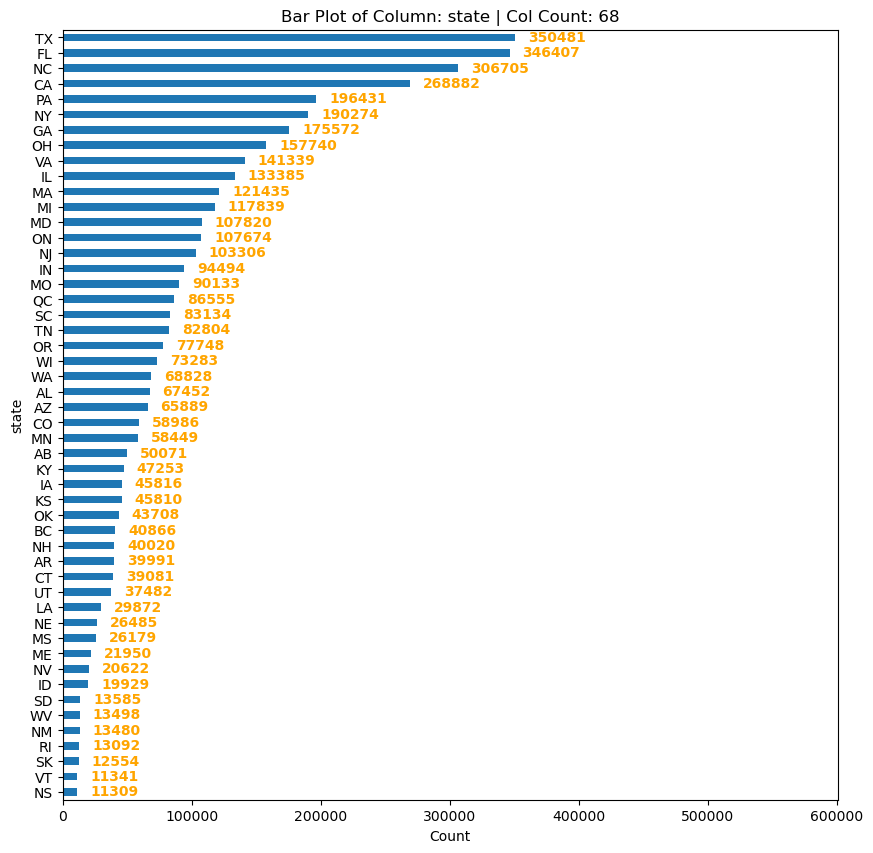

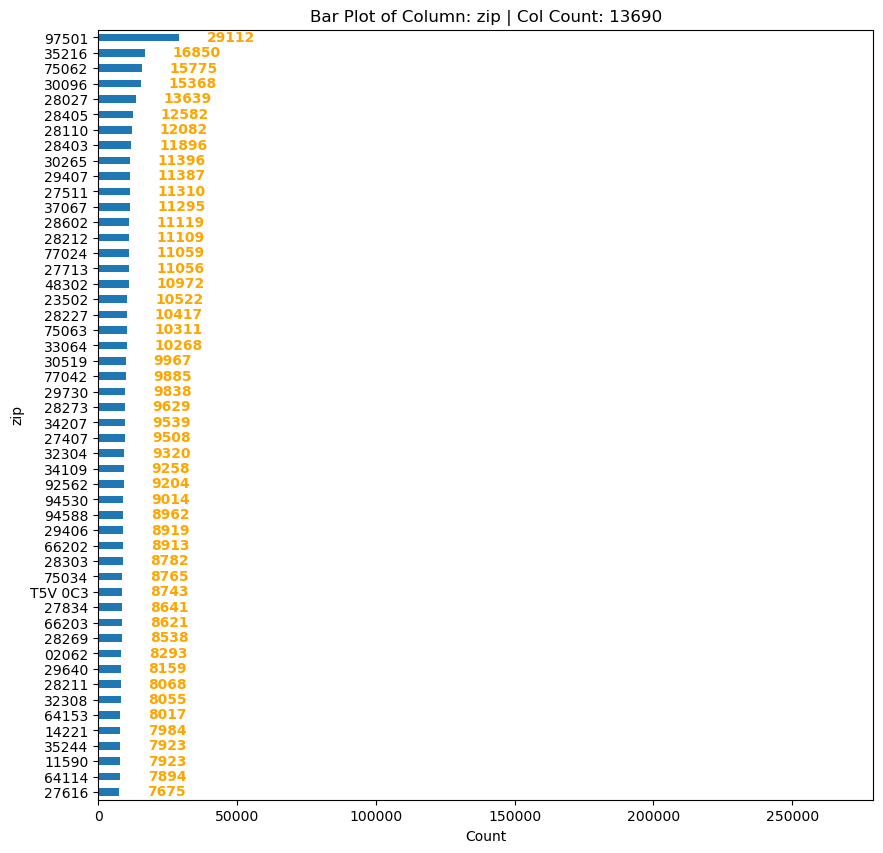

In [196]:
discrete_too_many_cols = ['make','model', 'trim', 'city','state', 'zip']
for dis_col in discrete_too_many_cols:
    # Set up plot
    plt.figure(figsize=(10,10))

    # Plot
    max_bar_count = 50
    val_count = decoded_df[dis_col].value_counts().sort_values(ascending = False)
    count = len(val_count.index)
    ax = val_count[:max_bar_count].plot(kind = "barh")
        
    # Show values
    for k, v in enumerate(val_count[:max_bar_count].values):
        ax.text(v + 1e4, k + 0.25, str(v), color='orange', fontweight='bold')

    # Title and Axis
    plt.title(f"Bar Plot of Column: {dis_col} | Col Count: {count}")
    plt.xlabel("Count")
    plt.ylabel(dis_col)
    plt.xlim([0,val_count.max()+2.5e5])
    
    # Show value in descending order
    plt.gca().invert_yaxis()

    # Show plot
    plt.show()

Note that:
- For these all 6 columns above, the top 100 categories has recognizable amount of data, which is good for the model to extract the information.
- However, the overwhelming amount of distinct values in these columns may expand our **feature space** drastically.
- For `make` and `state` there are less than 100 categories. We may still apply **dummy encoding** on it.
- However, for other columns, they have over 1000 or even 10000 distinct value. It may not possible to apply dummy encoding on it.  
We may need to further **group** them or apply other types of **encoding methods**. 

Let's move to other categorical columns.

#### Barplot for Columns with less then 50 distinct values

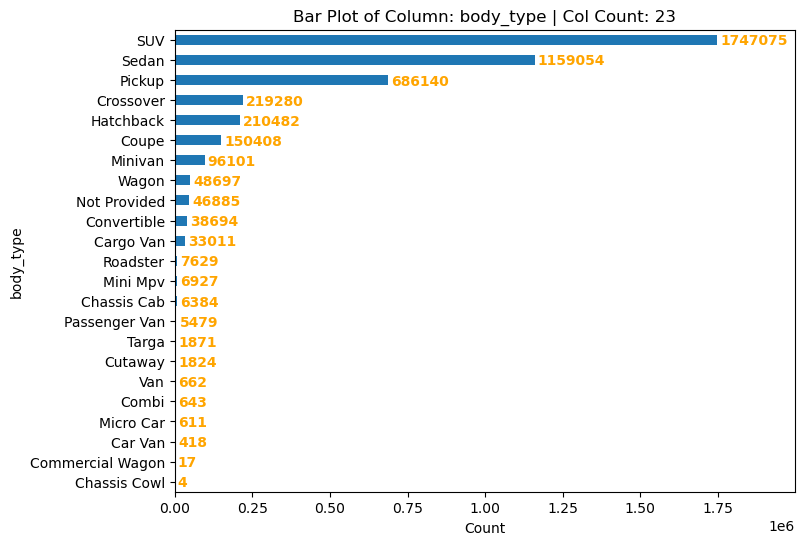

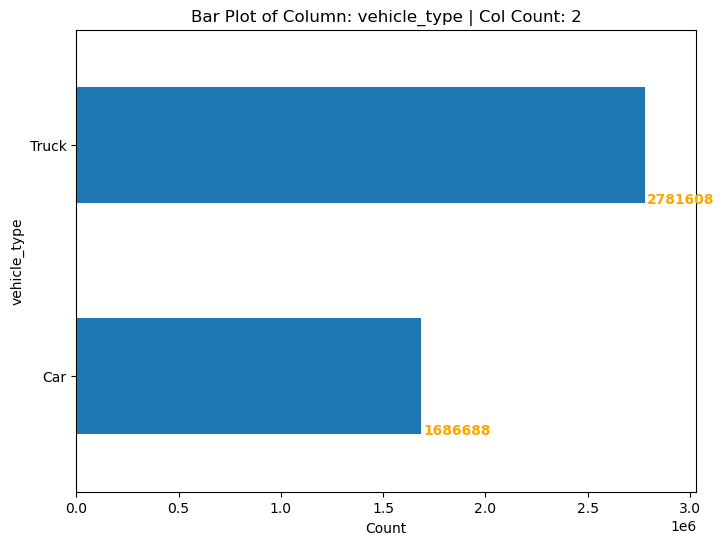

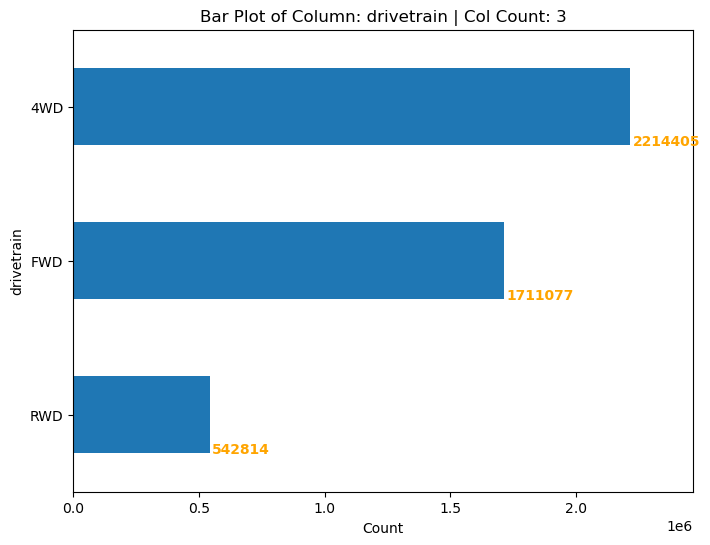

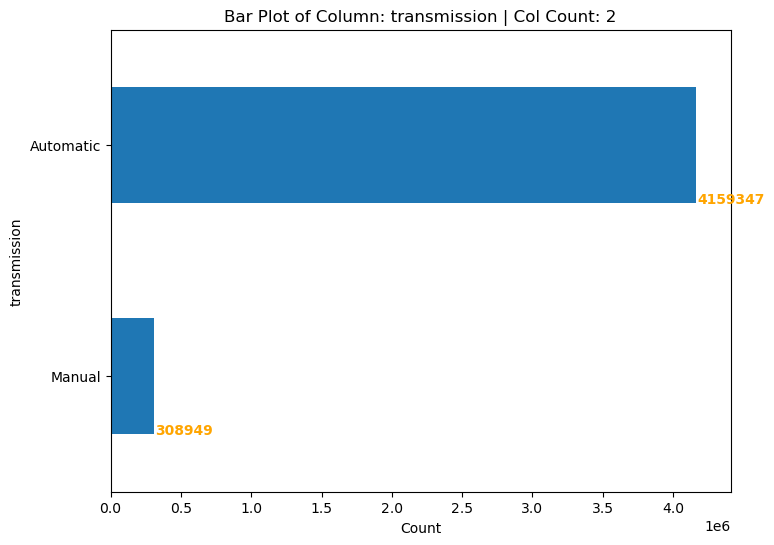

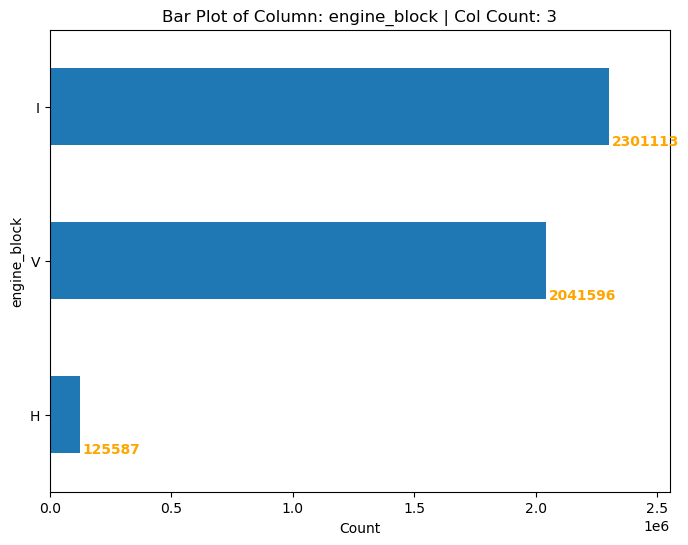

In [197]:
discrete_normal_cols = ['body_type', 'vehicle_type', 'drivetrain', 'transmission','engine_block']
for dis_col in discrete_normal_cols:
    # Set up plot
    plt.figure(figsize=(8,6))

    # Plot
    max_bar_count = 100
    val_count = decoded_df[dis_col].value_counts().sort_values(ascending = False)
    count = len(val_count.index)
    ax = val_count.sort_values(ascending = False).plot(kind = "barh",width = 0.5)
        
    # Show values
    for k, v in enumerate(val_count.values):
        ax.text(v + 1e4, k + 0.25, str(v), color='orange', fontweight='bold')

    # Title and Axis
    plt.title(f"Bar Plot of Column: {dis_col} | Col Count: {count}")
    plt.xlabel("Count")
    plt.ylabel(dis_col)
    plt.xlim([0,val_count.max()+2.5e5])
    
    # Show value in descending order
    plt.gca().invert_yaxis()

    # Show plot
    plt.show()

Insights: 
- For `body` column, we can see that there is a sharp cut between the value `Cargo Van` and `Roadster`. Perhaps this could be the cut off for dummy encoding.
- For `vehicle type` column, it is interesting that there are more `truck` vehicle type than `car` vehicle type. Maybe people in North America prefer to have a `truck` rather than a `car` for a larger loading capacity.
- For `drivetrain` column, we can see a comparable difference between all 3 types of drivetrain, but it is fine for our prediction.
- For `transmission` column, we can see that there are a lot of `automatic` transmission vehicle than `manual`.
- For `engine_block` column, we can see that most of the `engine_block` type are `I` or `V`. Maybe it is related to the vehicle `model` or the manufacturer (`make`). We may explore more in the bivariate analysis below.

---

### Bivariate Analysis - Numerical  <a class="anchor" id="num-bi"></a>

#### What numerical columns do we have?

In [198]:
target_var = "price_range"

In [199]:
# Get all columns with int or float type
all_num_col = list(decoded_df.select_dtypes(["int64","float64"]).columns)
all_num_col.remove(target_var)
all_num_col

['miles',
 'year',
 'engine_size',
 'fuel_Unleaded',
 'fuel_M85',
 'fuel_Diesel',
 'fuel_Biodiesel',
 'fuel_PremiumUnleaded',
 'fuel_Hydrogen',
 'fuel_E85',
 'fuel_CompressedNaturalGas',
 'fuel_Electric',
 'fuel_Lpg']

In [200]:
# Split the column that generate from the fuel_type column
fuel_col = all_num_col[3:]
fuel_col

['fuel_Unleaded',
 'fuel_M85',
 'fuel_Diesel',
 'fuel_Biodiesel',
 'fuel_PremiumUnleaded',
 'fuel_Hydrogen',
 'fuel_E85',
 'fuel_CompressedNaturalGas',
 'fuel_Electric',
 'fuel_Lpg']

In [201]:
num_col = all_num_col[:3]
num_col

['miles', 'year', 'engine_size']

#### `miles` vs `price_range`

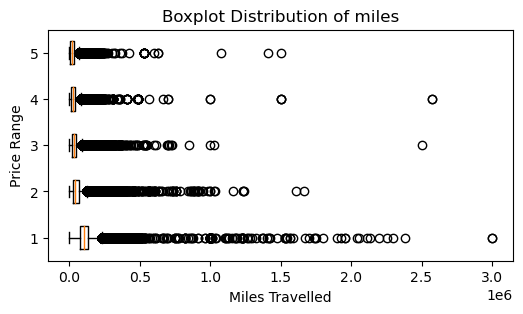

In [202]:
plt.figure(figsize = (6,3))
for p in set(decoded_df[target_var]):
    sub_df = decoded_df[decoded_df[target_var] == p][["miles",target_var]]
    plt.boxplot(x = sub_df["miles"],vert = False,positions = [p],widths = 0.5)
    
# Title & Axis
plt.title("Boxplot Distribution of miles")
plt.ylabel("Price Range")
plt.xlabel("Miles Travelled")

# Show
plt.show()

It seems that the data follows log-normal distribution. Let's try apply log scale on x-axis.

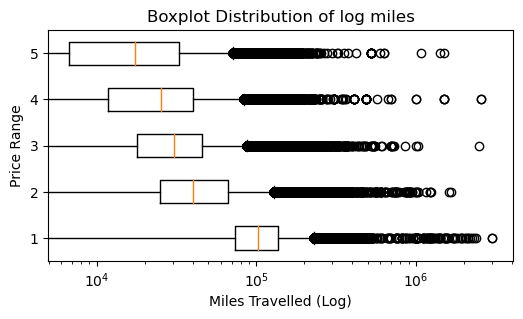

In [203]:
plt.figure(figsize = (6,3))
for p in set(decoded_df[target_var]):
    sub_df = decoded_df[decoded_df[target_var] == p][["miles",target_var]]
    plt.boxplot(x = sub_df["miles"],vert = False,positions = [p],widths = 0.5)
    
# Title & Axis
plt.title("Boxplot Distribution of log miles")
plt.ylabel("Price Range")
plt.xlabel("Miles Travelled (Log)")
plt.xscale("log")

# Show
plt.show()

Insight: 
- Note that Log transformation is applied on the x-axis (`miles`). Maybe we can apply log transformation during the feature enginering stage.
- From the boxplot above, we can see that the more `miles` a car has, the lower price range it would be.
- It would be very useful for predicting the price range.

**Further Analysis Opportunity**: 
- ANOVA test on the average log miles travelled of each group

#### `year` vs `price_range`

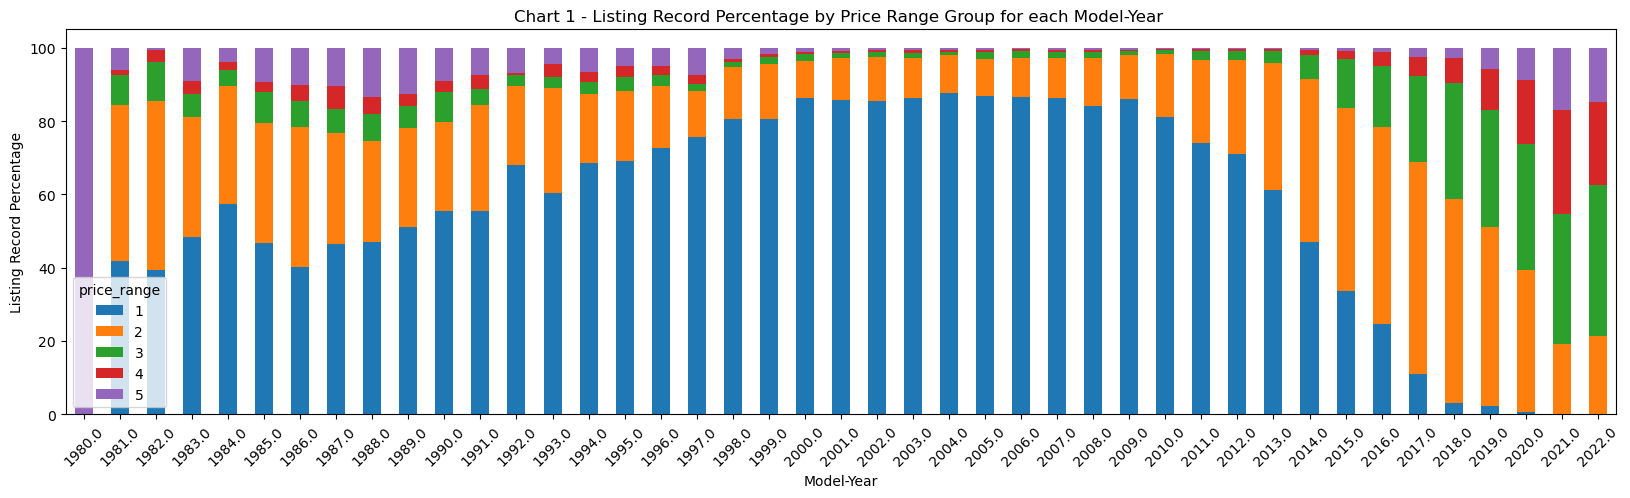

In [204]:

d = decoded_df.groupby('year')[target_var].value_counts(normalize=True).apply(lambda p: p*100).unstack(target_var)
d.plot(kind = "bar",stacked=True,figsize = (20,5))

    
# Title & Axis
plt.title("Chart 1 - Listing Record Percentage by Price Range Group for each Model-Year ")
plt.ylabel("Listing Record Percentage")
plt.xlabel("Model-Year")
plt.xticks(rotation = 45)


# Show
plt.legend(title=target_var)
plt.show()

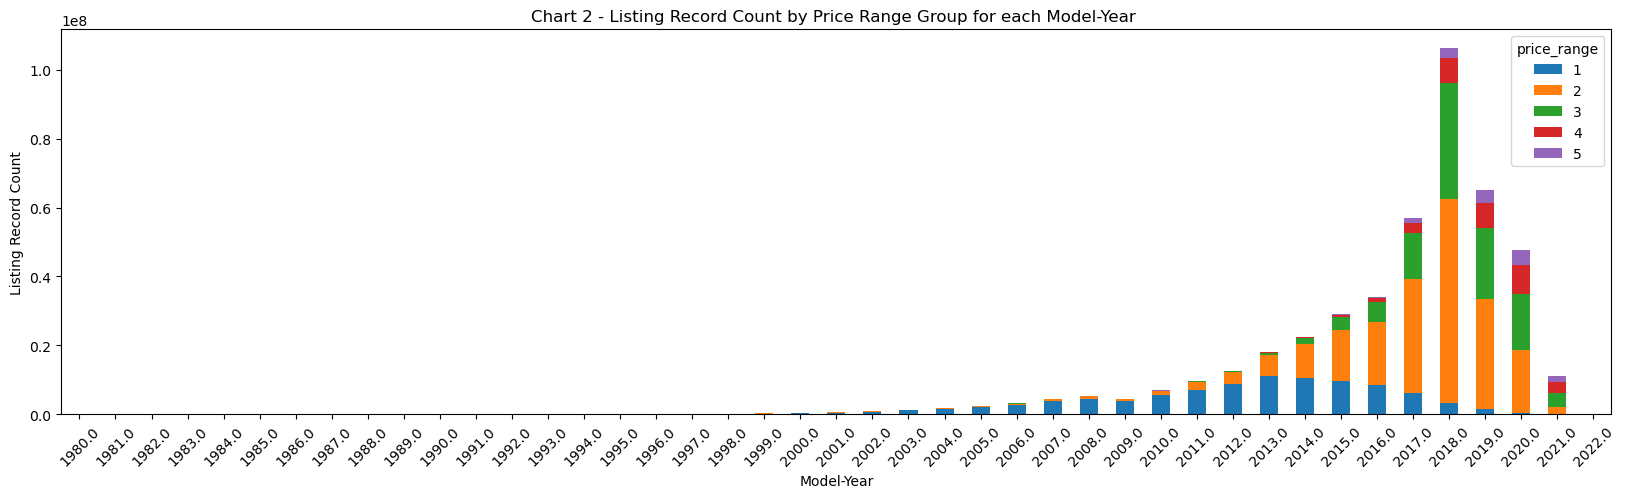

In [205]:
d = decoded_df.groupby('year')[target_var].value_counts(normalize=False).apply(lambda p: p*100).unstack(target_var)
d.plot(kind = "bar",stacked=True,figsize = (20,5))

# Title & Axis
plt.title("Chart 2 - Listing Record Count by Price Range Group for each Model-Year ")
plt.ylabel("Listing Record Count")
plt.xlabel("Model-Year")
plt.xticks(rotation = 45)

# Show
plt.legend(title=target_var)
plt.show()

Insight: 
- We can see that the Vehicle Model launched in recently year usually have higher price (Increase in market share in group 3,4,5).
- In 1980, there are 100% of listing vehicle with price range of 5. This may be caused by the lack of listing of old vehicle model. These listings could also be the famous model which could be antique.
- The possible reasons for the pattern in chart above:
    1. Inflation could be one of the reasons why the percentage of listing with group 1 is vanishing in the last few years. Price for a used car keep rising in the last few years.
    2. Vehicle with model year before 2000 could be so few that induced some weird patterns in Chart 1.


#### `engine_size` vs `price_range`

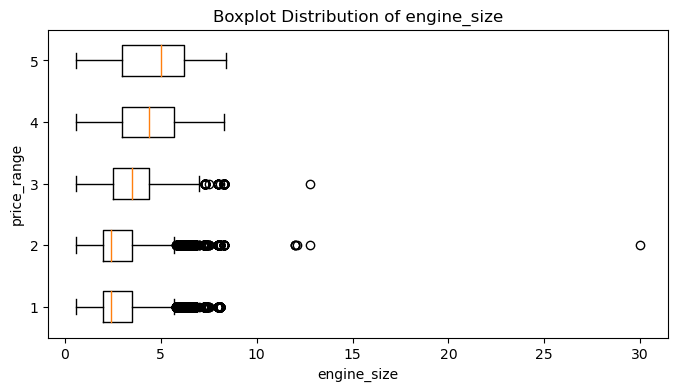

In [206]:
plt.figure(figsize = (8,4))
for p in set(decoded_df[target_var]):
    sub_df = decoded_df[decoded_df[target_var] == p][["engine_size",target_var]]
    plt.boxplot(x = sub_df["engine_size"],vert = False,positions = [p],widths = 0.5)
    
# Title & Axis
plt.title("Boxplot Distribution of engine_size")
plt.ylabel(target_var)
plt.xlabel("engine_size")

# Show
plt.show()

It seems that there is an outlier on the right that affect the plot. Lets set the x-axis range to [0,15]

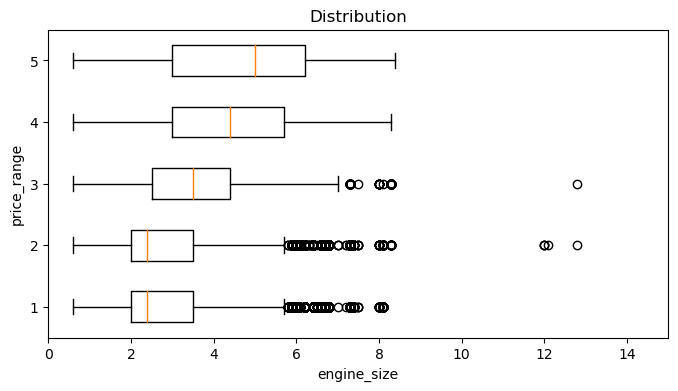

In [207]:
plt.figure(figsize = (8,4))
for p in set(decoded_df[target_var]):
    sub_df = decoded_df[decoded_df[target_var] == p][["engine_size",target_var]]
    plt.boxplot(x = sub_df["engine_size"],vert = False,positions = [p],widths = 0.5)
    
# Title & Axis
plt.title("Distribution")
plt.ylabel(target_var)
plt.xlabel("engine_size")
plt.xlim([0,15])

# Show
plt.show()

Insight: 
- We can see that the for price range group 1 & 2, they are very similar. 
- However, for group 3 & 4 & 5, they have comparably larger engine_size than group 1 & 2

**Further Analysis Opportunity**: 
- ANOVA test on the average engine_size of each group

#### `fuel_type` enconded columns vs `price_range`

In [208]:
fuel_col

['fuel_Unleaded',
 'fuel_M85',
 'fuel_Diesel',
 'fuel_Biodiesel',
 'fuel_PremiumUnleaded',
 'fuel_Hydrogen',
 'fuel_E85',
 'fuel_CompressedNaturalGas',
 'fuel_Electric',
 'fuel_Lpg']

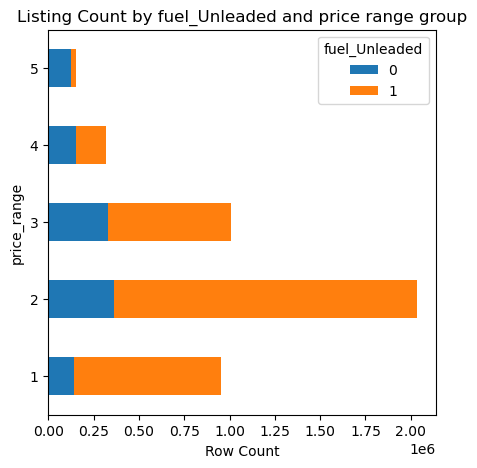

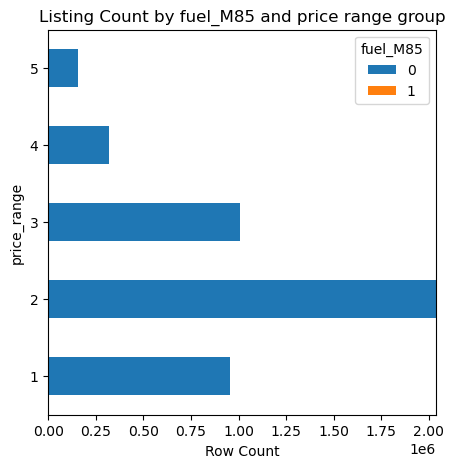

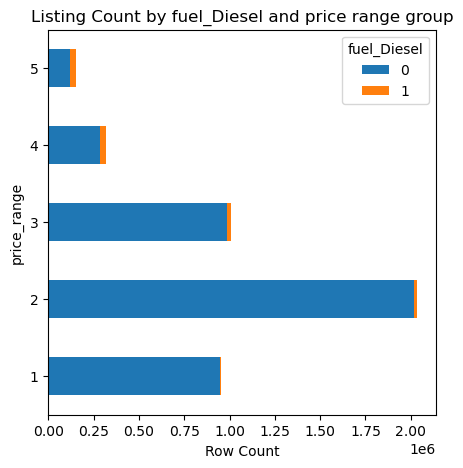

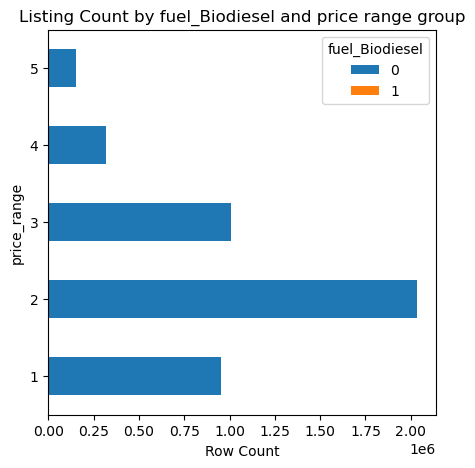

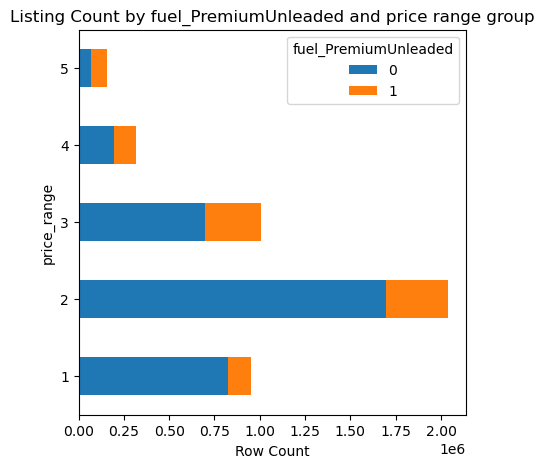

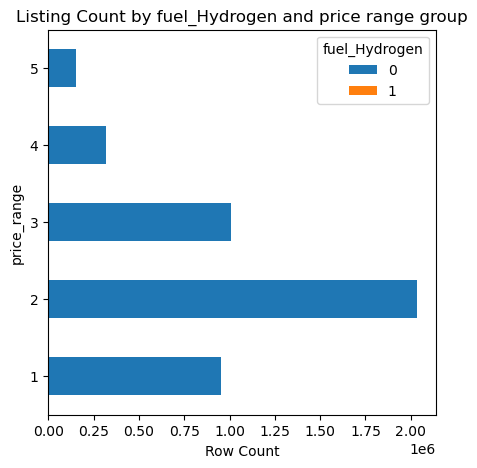

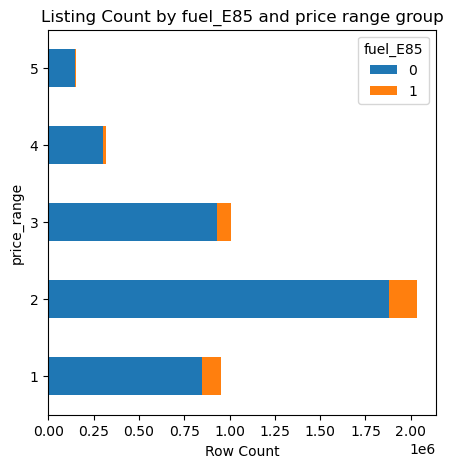

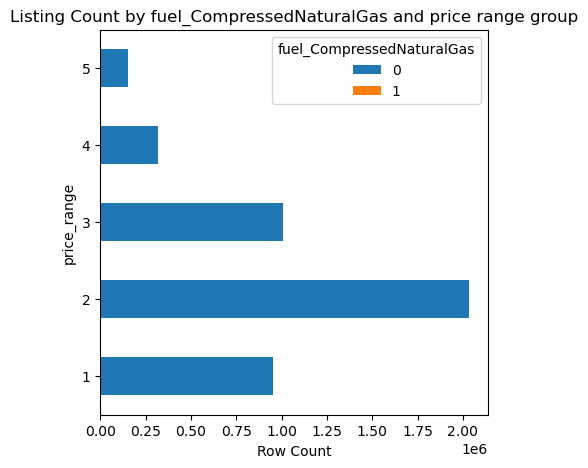

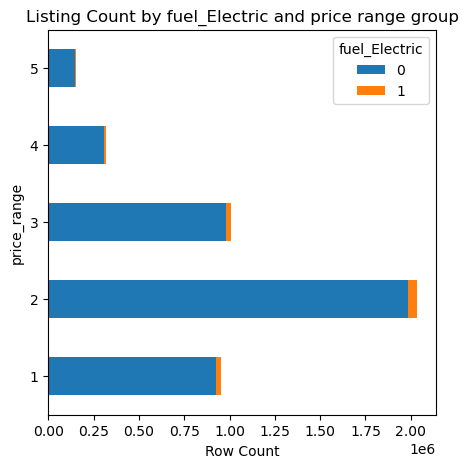

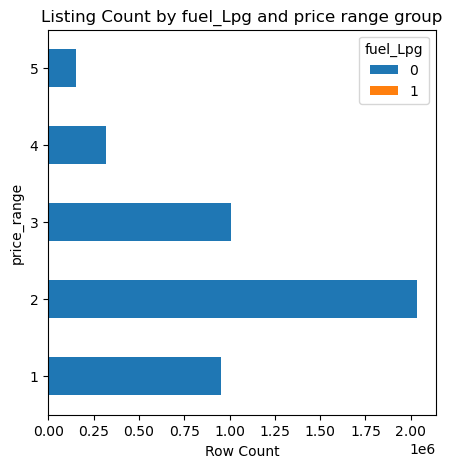

In [209]:
for fuel in fuel_col:
    decoded_df[[fuel,target_var]].value_counts().unstack().T.plot(kind="barh",stacked = True,figsize = (5,5))
    plt.ylabel(target_var)
    plt.xlabel("Row Count")
    plt.title(f"Listing Count by {fuel} and price range group")
    plt.show()

In [210]:
decoded_df[fuel_col].sum().sort_values(ascending = False)

fuel_Unleaded                3358936
fuel_PremiumUnleaded          983918
fuel_E85                      363216
fuel_Electric                 119223
fuel_Diesel                   110271
fuel_Biodiesel                   542
fuel_CompressedNaturalGas        299
fuel_Hydrogen                    179
fuel_Lpg                           7
fuel_M85                           2
dtype: int64

Insights:
- For fuel type `Biodiesel`, `M85`, `Lpg`, `CompressedNaturalGas` and `Hydrogen`, most of the vehicle listing are not supporting these fuel type.
- Vehicles in most of the listing support `PremiumUnleaded` or `Unleaded`.

**Further Analysis Opportunity**: 
- Chi-Squared Independency Test betweek each fuel_type enconded column and `price_range`

---

### Bivariate Analysis - Categorical  <a class="anchor" id="cat-bi"></a>

#### Relationship between categorical & target

#### What Categorical columns do we have?

In [211]:
target_var = "price_range"

In [212]:
# Get all columns with int or float type
all_cat_col = list(decoded_df.select_dtypes(["object"]).columns)

# vin is the unique identifier for each vehicle
all_cat_col.remove("vin")

all_cat_col

['make',
 'model',
 'trim',
 'body_type',
 'vehicle_type',
 'drivetrain',
 'transmission',
 'engine_block',
 'city',
 'state',
 'zip']

In [213]:
# Number of unique value in these categorical columns
decoded_df[all_cat_col].nunique()

make               63
model            1252
trim             2492
body_type          23
vehicle_type        2
drivetrain          3
transmission        2
engine_block        3
city             6095
state              68
zip             13690
dtype: int64

Note that:
- For columns with large number of unique values (> 20), we will skip the plotting here.

**Further Analysis Opportunity**: 
- We will apply further EDA for those columns with large number of unique values, after applying enconding methods in feature engineering stage.

#### Categorical columns vs `price_range`

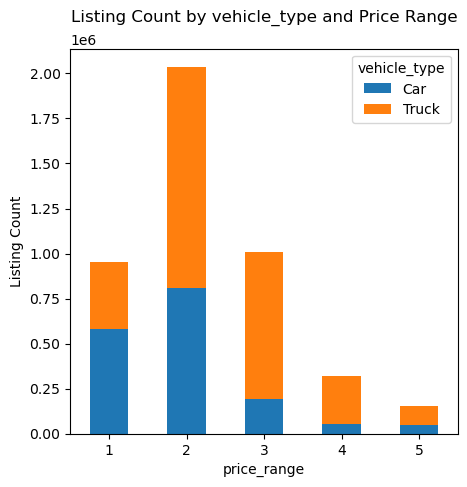

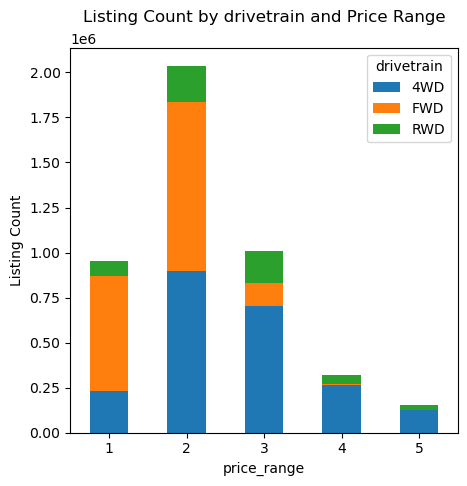

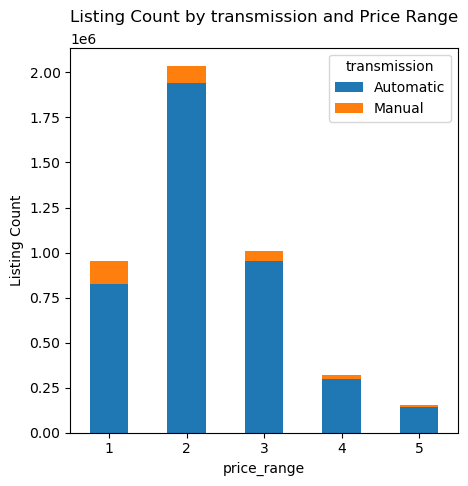

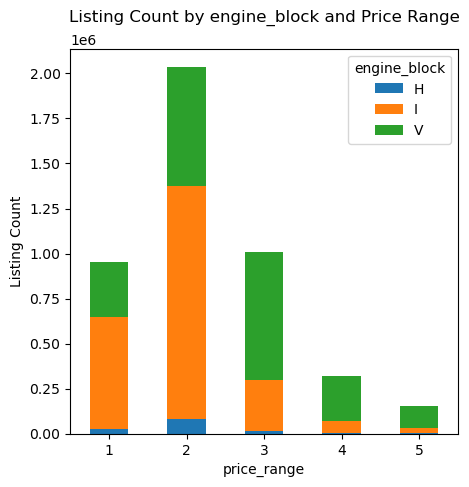

In [214]:
for col in ["vehicle_type","drivetrain","transmission","engine_block"]:
    d = decoded_df.groupby(target_var)[col].value_counts().unstack(col)
    d.plot(kind = "bar",stacked=True,figsize = (5,5))

    # Title & Axis
    plt.title(f"Listing Count by {col} and Price Range\n")
    plt.ylabel("Listing Count")
    plt.xlabel(target_var)
    plt.xticks(rotation = 0)

    # Show
    plt.legend(title=col)
    plt.show()

Insight: 
- In `drivetrain` vs `price_range`, vehicle in price range group 4 & 5 usually is not `FWD` type.
- For other pairs, there is no any obvious and comparable observation. Perhaps we can conduct further EDA with Hypothesis Testing.

**Further Analysis Opportunity**: 
- Chi-Squared Independent Test for above four pairs

---

### Further EDA <a class="anchor" id="fur-eda"></a>

- ANOVA test on the average log `miles` travelled of each group
- ANOVA test on the average `engine_size` of each group
- Chi-Squared Independency Test between each fuel_type enconded column (columns starting with `fuel_`) and `price_range`
- Further EDA for those columns with large number of unique values (`make`, `model`, `trim`, `body`, `city`, `state` & `zip`), after applying enconding methods.
- Chi-Squared Independency Test between [`vehicle_type`, `drivetrain`, `transmission` & `engine_block`] and `price_range`

[Back-to-top](#toc)

---

In [215]:
decoded_df.dtypes

vin                           object
miles                        float64
year                         float64
make                          object
model                         object
trim                          object
body_type                     object
vehicle_type                  object
drivetrain                    object
transmission                  object
engine_size                  float64
engine_block                  object
city                          object
state                         object
zip                           object
price_range                    int64
fuel_Unleaded                  int64
fuel_M85                       int64
fuel_Diesel                    int64
fuel_Biodiesel                 int64
fuel_PremiumUnleaded           int64
fuel_Hydrogen                  int64
fuel_E85                       int64
fuel_CompressedNaturalGas      int64
fuel_Electric                  int64
fuel_Lpg                       int64
dtype: object